In [83]:
import numpy as np
import pandas as pd
import commonFunctions as func
import matplotlib.pyplot as plt
import folium

In [84]:
# pinnaclePoints = pd.read_csv('../formattedSummits/pinnaclePoints_raw.txt', 
#                              sep = ',', 
#                              header = None,
#                              names = ['id', 'latitude', 'longitude', 'elevation', 'h_distance'])
# pinnaclePoints = pinnaclePoints[['latitude', 'longitude', 'elevation']]
# pinnaclePoints['prominence'] = pinnaclePoints.elevation
# pinnaclePoints['name_en'] = ''
# pinnaclePoints['name_local'] = ''
# pinnaclePoints['wikipedia'] = ''

pinnaclePoints = pd.read_csv('../pinnaclePoints.txt', sep=',').fillna('')

pinnaclePoints['elevationRank'] = pinnaclePoints.elevation.rank(ascending = False).astype(int)
pinnaclePoints['prominenceRank'] = pinnaclePoints.prominence.rank(ascending = False).astype(int)

In [86]:
def getPinnaclePointColor(elevation):
    if elevation >= 6000:
        return 'red'
    elif elevation >= 4000:
        return 'orange'
    elif elevation >= 2000:
        return 'yellow'
    else:
        return 'limegreen'
    
def addPointToMap(summit, isEasterEgg=False, extraToolTip=''):
    
    # adding a * for pinnacle points I've visited
    visited = ''
    if summit.prominenceRank in myCompletedPrmRanks:
        visited = '*'
            
    summitTitle = summit.name + visited
 
    wikiHTML = ''
    if summit.wikipedia != '':
        wikiHTML = f'<a href=https://en.wikipedia.org/wiki/{summit.wikipedia.replace(" ","_")}>Wikipedia</a> | '
        
    latRounded = round(summit.latitude, 4)
    lngRounded = round(summit.longitude, 4)
    
    toolTip = (f'<b>{summitTitle}</b><br>' + 
               f'Location: {latRounded}, {lngRounded}<br>' + 
               f'Elevation: {round(summit.elevation)} m (Rank: {summit.elevationRank})<br>' +
               f'Prominence: {round(summit.prominence)} m (Rank: {summit.prominenceRank})<br>' + 
               f'Links: {wikiHTML}' + 
               f'<a href=https://www.peakbagger.com/search.aspx?tid=R&lat={latRounded}&lon={lngRounded}&ss=>PeakBagger</a>')
    
    if isEasterEgg == True and extraToolTip != '':
        toolTip += f'<br><br>{extraToolTip}'
        
    if isEasterEgg == False:
        marker = folium.RegularPolygonMarker(
            location = [summit.latitude, summit.longitude],
            number_of_sides=3,
            radius = 11,
            fill = True,
            fill_color = getPinnaclePointColor(summit.elevation),
            fill_opacity = 1,
            weight = 1,
            color = 'black',
            gradient = False,
            rotation = 30
        ).add_to(pinnaclePointMap)
    
    # for better usability on mobile
    invisibleCircle = folium.CircleMarker(
        location = [summit.latitude, summit.longitude],
        radius = 11,
        fill = True,
        fill_opacity = 0,
        weight = 0
    ).add_to(pinnaclePointMap)
    
    invisibleCircle.add_child(folium.Popup(toolTip, max_width=300).add_to(invisibleCircle))
    
summits = pinnaclePoints.sort_values('elevation', ascending=True)
pinnaclePointMap = folium.Map(location=[0, 0], zoom_start=2, tiles=None, world_copy_jump=True)

folium.raster_layers.TileLayer(name = 'Satellite',
                               maxZoom = 19,
                               tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', 
                               attr = 'Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community'
                              ).add_to(pinnaclePointMap)
folium.TileLayer(
          'https://{s}.tile.opentopomap.org/{z}/{x}/{y}.png', 
          attr = 'Map data: &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, <a href="http://viewfinderpanoramas.org">SRTM</a> | Map style: &copy; <a href="https://opentopomap.org">OpenTopoMap</a> (<a href="https://creativecommons.org/licenses/by-sa/3.0/">CC-BY-SA</a>)',
          name = 'Elevation',
          maxZoom = 16
          ).add_to(pinnaclePointMap)
folium.TileLayer(
          name = 'Street',
          ).add_to(pinnaclePointMap)

folium.LayerControl().add_to(pinnaclePointMap)

'''
Easter Egg Start
invisible but clickable
'''
summitCols = ['latitude', 
              'longitude', 
              'elevation', 
              'prominence', 
              'name', 
              'wikipedia', 
              'elevationRank',
              'prominenceRank',
              'toolTip']

mostPrmNotPptoolTip = ('The most prominent mountain to<br>' + 
                       'not be a pinnacle point. The 14th<br>' + 
                       'most prominent mountain on earth.')

easterEggData = [[35.2375, 74.5891, 
                  8126, 4608, 
                  '', 'Nanga Parbat', 
                  'N/A', 'N/A',
                  mostPrmNotPptoolTip]]

easterEggSummits = pd.DataFrame(easterEggData, columns=summitCols)

# to keep track of pinncle points I have visited
myCompletedPrmRanks = [521]

easterEggSummits.apply(lambda summit: addPointToMap(summit, 
                                                    isEasterEgg = True, 
                                                    extraToolTip = summit.toolTip), axis=1)
'''
Easter Egg End
'''

summits.apply(addPointToMap, axis=1)

legend_html = """
    <div style="
        background-color: rgba(255, 255, 255, 0.9);
        padding: 5px;
        font-size: 12px;
        position: absolute;
        top: 12px;
        right: 70px;
        z-index: 1000;
    ">
        <div style="display: flex; align-items: center; cursor: pointer;" onclick="toggleLegend()">
            <div id="chevronIcon" style="margin-left: 11px; margin-right: 15px; width: 10px; height: 10px; 
                border-style: solid; border-width: 0 2px 2px 0; transform: rotate(45deg);"></div>
            <h4 style="margin: 0; margin-right: 30px;">Pinnacle Points</h4>
        </div>
        <div id="legendContent" style="display: none; margin-top: 5px;">
            <center style="margin-top: 15px; margin-bottom: 15px;">
                A <b>pinnacle point</b> is a point<br>from which no higher point<br>can be seen [Count: 601]
            </center>
            <p style="margin: 0;">
                <div class="row">
                    <div class="col-1" style="margin-left: 16px; margin-right: 2px; margin-top: 3px">
                        <svg width="14" height="14">
                            <polygon points="0,14 7,1 14,14" fill="black" />
                            <polygon points="1.5,13 7,3.2 12.5,13" fill="limegreen" />
                        </svg>
                    </div>
                    <div class="col" style="margin-top: 7px">
                        <div class="col">Elevation < 2000 m</div>
                    </div>
                </div>
            </p>
            <p style="margin: 0;">
                <div class="row">
                    <div class="col-1" style="margin-left: 16px; margin-right: 2px; margin-top: 3px">
                        <svg width="14" height="14">
                            <polygon points="0,14 7,1 14,14" fill="black" />
                            <polygon points="1.5,13 7,3.2 12.5,13" fill="yellow" />
                        </svg>
                    </div>
                    <div class="col" style="margin-top: 7px">
                        <div class="col">2000 m &le; Elevation < 4000 m</div>
                    </div>
                </div>
            </p>
            <p style="margin: 0;">
                <div class="row">
                    <div class="col-1" style="margin-left: 16px; margin-right: 2px; margin-top: 3px">
                        <svg width="14" height="14">
                            <polygon points="0,14 7,1 14,14" fill="black" />
                            <polygon points="1.5,13 7,3.2 12.5,13" fill="orange" />
                        </svg>
                    </div>
                    <div class="col" style="margin-top: 7px">
                        <div class="col">4000 m &le; Elevation < 6000 m</div>
                    </div>
                </div>
            </p>
            <p style="margin: 0;">
                <div class="row">
                    <div class="col-1" style="margin-left: 16px; margin-right: 2px; margin-top: 3px">
                        <svg width="14" height="14">
                            <polygon points="0,14 7,1 14,14" fill="black" />
                            <polygon points="1.5,13 7,3.2 12.5,13" fill="red" />
                        </svg>
                    </div>
                    <div class="col" style="margin-top: 7px">
                        <div class="col">Elevation &ge; 6000 m</div>
                    </div>
                </div>
            </p>
        </div>
    </div>

    <script>
        function toggleInfoWindow() {
            var infoWindow = document.getElementById("infoWindow");
            var infoIcon = document.getElementById("informationIcon");

            if (infoWindow.style.display === "block") {
                infoWindow.style.display = "none";
                infoIcon.style.fill = "rgba(255, 255, 255, 0.9)";
            } else {
                infoWindow.style.display = "block";
                infoIcon.style.fill = "rgba(255, 255, 0, 0.9)";
            }
        }
    </script>

    <script>
        function toggleLegend() {
            var contentDiv = document.getElementById("legendContent");
            var chevronIcon = document.getElementById("chevronIcon");

            if (contentDiv.style.display === "block") {
                contentDiv.style.display = "none";
                chevronIcon.style.transform = "rotate(45deg)";
            } else {
                contentDiv.style.display = "block";
                chevronIcon.style.transform = "rotate(225deg)";
            }
        }
    </script>
"""

pinnaclePointMap.get_root().html.add_child(folium.Element(legend_html))

pinnaclePointMap.get_root().html.add_child(folium.Element(f'''
    <div id="infoIcon" style="position: absolute; bottom: 12px; right: 0px; cursor: pointer; z-index: 1001;">
        <svg id="informationIcon" width="100" height="100" viewBox="0 0 50 50" fill="white" stroke="black" stroke-width="4" 
            stroke-linecap="round" stroke-linejoin="round" onclick="toggleInfoWindow()">
            <circle cx="24" cy="24" r="20"></circle>
            <line x1="24" y1="32" x2="24" y2="24"></line>
            <line x1="24" y1="16" x2="24" y2="16"></line>
        </svg>
    </div>
    <div id="infoWindow" style="display: none; overflow-y: auto; position: absolute; top: 50%; left: 50%; 
        transform: translate(-50%, -50%); background-color: rgba(255, 255, 255, 0.9); padding: 12px; width: 90%; 
        height: 75%;  z-index: 1000;">
        
        <h2>Definitions</h2>
        <p>
            A <b>pinnacle point</b> is a point from which no higher point can be seen. Across the globe, 601 have been found. 
            These are all pinnacle points with more than 300 m of prominence. 
            The algorithm used for finding pinnacle points is outlined below, along with sources of error.
            The curvature of the Earth, and atmospheric refraction are taken into account.</p>
        <p>
            The <b>prominence</b> of a summit is how far down you have to go in order to get to higher elevation. 
            It can be thought of as how much a summit rises above its surroundings.
        </p>
        <p>
            The <b>direct line of sight</b> is the straight line connecting 2 points.
        </p>
        <p>
            The <b>light path</b> is the bent path light takes in the atmosphere between 2 points as a result of refraction.
        </p>

        <h2>Sources</h2>
        <h4><a href="http://everymountainintheworld.com/">Mountains by Topographic Prominence</a></h4>
        <p>
            Thanks to Andrew Kirmse and the Prominence Group for finding 11,866,713 summits with a 
            prominence greater than 100 feet (~30 m).
        </p>
        <h4><a href="https://ototwmountains.com/">On-Top-Of-The-World Mountains</a></h4>
        <p>
            An on-top-of-the-world mountain (OTOTW) is a summit where no land rises 
            above the horizontal plane from the summit. 
            Since any land that rises above the horizontal plane would have higher elevation than the summit itself, if a summit 
            is not an OTOTW then it can't be a pinnacle point either. In other words, pinnacle points are a subset of 
            OTOTWs. Thanks to Kai Xu for finding 6,464 OTOTWs around the world. Andreas Geyer-Schulz deserves 
            mention as well for his <a href="https://nuntius35.gitlab.io/extremal_peaks/">extremal peaks</a>.
        </p>
        <h4><a href="https://aty.sdsu.edu/explain/atmos_refr/horizon.html">Atmospheric Refraction</a></h4>
        <p>
            Different layers of the atmosphere have different refractive indices due to varying temperatures and pressures. 
            Although light's exact path in the air is difficult to calculate and depends on many factors, a ray's path can be 
            approximated as the arc of a circle with radius 7 times greater than Earth's.
        </p>
        
        <h2>Error</h2>
        <ol>
            <li>
                When the OTOTWs were found, all summits with less than 300 m of prominence were omitted. 
                This cutoff is carried forward to pinnacle points.
            </li>
            <li>
                The earth is approximated as a sphere instead of an ellipsoid. This is done for simpler math.
            </li>
            <li>
                Only 100 elevations are sampled when determining if two points have an unobstructed light path. 
                This can lead to points that can block the light path being missed. 
                By increasing the number of elevations sampled, more pinnacle points would be found.
            </li>
            <li>
                To take atmospheric refraction into account, light rays are approximated as arcs of circles. 
                The path light takes in the atmosphere is infact much more complex and depends on many factors.
                Note, since the distance you can see from a given point depends on temperature and pressure, 
                the distance you can see technically changes with the season and even the time of day. 
                Additionally, some assumptions used to take atmospheric refraction into account only hold true 
                for heights small compared to the 8 km height of the 
                <a href="https://aty.sdsu.edu/explain/thermal/hydrostatic.html#homog">homogeneous atmosphere</a>. 
                This project is slightly outside of this scope.
            </li>
            <li>
                There is some inherent error in the data. The datasets have a resolution of 30 m (1 arcsecond), 
                and the elevation API uses 90 m (3 arcseconds). All data sources are surface elevation models, 
                so trees and buildings are included. 
            </li>
        </ol>


        <h2>Algorithms</h2>
        <h4>Finding Pinnacle Points</h4>
        <ol>
            <li>
                Categorize the 11,866,713 summits into patches based on longitude and latitude. 
                This is done for faster processing later. The patch size is 10 deg x 10 deg with some extra to take into account
                the fact that summits may be able to see beyond the patch they are in.
            </li>
            <li>
                Find the maximum horizon distance (MHD) defined as √(2*(7/6)*R_earth*Elevation) for each summit and OTOTW. 
                The factor of 7/6 is to account for atmospheric refraction increasing the distance that can be seen.
            </li>
            <li>
                Define a list of remaining OTOTWs as the full list of OTOTWs.
            </li>
            <li>
                Find the highest elevation remaining OTOTW (HERO).
            </li>
            <li>
                Find all other remaining OTOTWs where the sum of the OTOTW's MHD and the HERO's MHD 
                is greater than the distance between them. In other words, find all OTOTWs that have a chance 
                of being seen by the HERO. For each, do light path analysis (described below) to find which OTOTWs 
                can actually be seen by the HERO. Each will have a lower elevation than the HERO, so they are removed from the 
                list of remaining OTOTWs.
            </li>
            <li>
                Find the HERO's patch.
            </li>
            <li>
                Find all summits in the patch where both the summit's elevation is greater than the HERO's elevation 
                and the sum of the summit's MHD and the HERO's MHD is greater than the distance between them. In other 
                words, find all summits that have a chance of disqualifying the HERO from being a pinnacle point. For each, 
                do light path analysis to determine if any summits can actually see the HERO. If any can, the HERO is 
                not a pinnacle point and is removed from the list of remaining OTOTWs. Otherwise, the HERO is a pinnacle 
                point and is added to a list.
            </li>
            <li>
                Repeat 4-8 until there are no remaining OTOTWs.
            </li>
        </ol>
        <h4>Light Path Analysis</h4>
        <ol>
            <li>
                Generate a list of 100 equidistant latitude-longitude points between the two input points 
                along the geodesic.
            </li>
            <li>
                Find the elevation of each point using an 
                API (<a href="https://open-meteo.com/en/docs/elevation-api">Open-Meteo</a>), 
                and find the distance of each point to the first point.
            </li>
            <li>
                Translate each distance-elevation point such that the first point is at (0, 0).
            </li>
            <li>
                Apply a translation to each distance-elevation point based on how far away the 
                point is to take the curvature of the earth into account.
            </li>
            <li>
                Rotate the points to make the last point at the 0 elevation line. In other words, 
                make direct line of sight along the x-axis.
            </li>
            <li>
                Find the light path's distance above direct line of sight for each point.
            </li>
            <li>
                If any of the points are of greater elevation than the light path, 
                the light path is blocked. Otherwise, there is an unobstructed light path.
            </li>
        </ol>
        
        <h2>App Download</h2>
        <p>
            Since the app is only available by downloading the APK, only Android devices are currently supported. 
            Follow these steps to get the app on your Android device:
            <ol>
                <li>Open <a href="https://github.com/jgbreault/PinnaclePoints/blob/main/misc/pinnaclePoints.apk">this page</a> 
                    on your Android device.</li>
                <li>Click the button that looks like [<b>...</b>] (three dots).</li>
                <li>Click [<b>Download</b>]. Open the APK on your phone when it is done downloading. 
                    You may get a message similar to "<i>For your security, 
                    your phone is not allowed to install apps from this source</i>". 
                    You'll have to go to your settings and allow unknown installs from this source.
                    Feel free to change it back afterwards.</li>
                <li>Click [<b>Install</b>].</li>
            </ol>
        </p>

        <h2>Contact</h2>
        <p>
            Contact me at jamiegbreault@gmail.com.
            Check out the latest on <a href="https://github.com/jgbreault/PinnaclePoints">my github</a>. 
            There you will find a txt file of the pinnacle points, the algorithm used, 
            and derivations of some of the math. Pinnacle points I have visited myself are marked with 
            an asterisk [Count: 1].
        </p>
        <p style="padding-bottom: 35px;">
            Here's  
            <a href="https://www.rhsoc.uk/blog/hill-list-updates/two-classification-criteria-for-the-hills-and-mountains-of-britain/">
            an article</a> on OTOTWs and pinnacle points if you are interested.
        </p>
    </div>
'''))

pinnaclePointMap

ValueError: 9 columns passed, passed data had 10 columns

In [4]:
pinnaclePointMap.save('../index.html')

In [10]:
LAT = 0 # latitude
LNG = 1 # longitude
def findClosestPinnaclePoints(lat, lng, summits=pinnaclePoints, num=5):
        
    distances = [func.geod.line_length([lng,
                                        row[LNG]],
                                       [lat,
                                        row[LAT]]) for row in summits.values]
    
    distances = round(pd.Series(distances).sort_values().divide(1000), 1)
    closestDistances = distances.head(num)
    closestPinnaclePoints = summits.loc[closestDistances.index]
    closestPinnaclePoints['distance_km'] = closestDistances
    closestPinnaclePoints = closestPinnaclePoints[['name',
                                                   'latitude',
                                                   'longitude',
                                                   'elevation',
                                                   'elevationRank',
                                                   'prominence',
                                                   'prominenceRank',
                                                   'distance_km']]
        
    return closestPinnaclePoints

findClosestPinnaclePoints(46.016487, -79.723910, num=3)

name_en name_local  latitude  longitude  elevation  elevationRank  \
517                      45.6489   -78.2569     582.67            518   
530                      46.1111   -81.2894     538.28            531   
484                      47.3175   -80.7525     690.96            485   

     prominence  prominenceRank  distance_km  
517      386.45             521        120.8  
530      300.94             601        121.2  
484      388.44             517        164.6

Light Path: Yes
Direct Line of Sight: No
Distance: 538 km


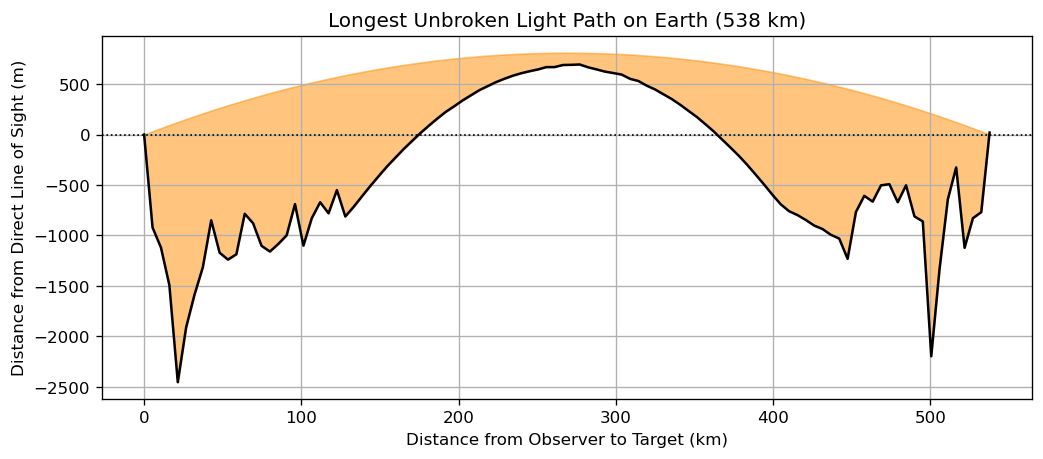

In [3]:
# testing longest line of sight on earth (538 km)
func.plotLosElevationProfile(41.0593, 77.68419, 
                             5982, 
                             36.295306, 78.755049, 
                             6421,
                             savePlot = True,
                             plotTitle = 'Longest Unbroken Light Path on Earth (538 km)')

Light Path: No
Direct Line of Sight: No
Distance: 93 km


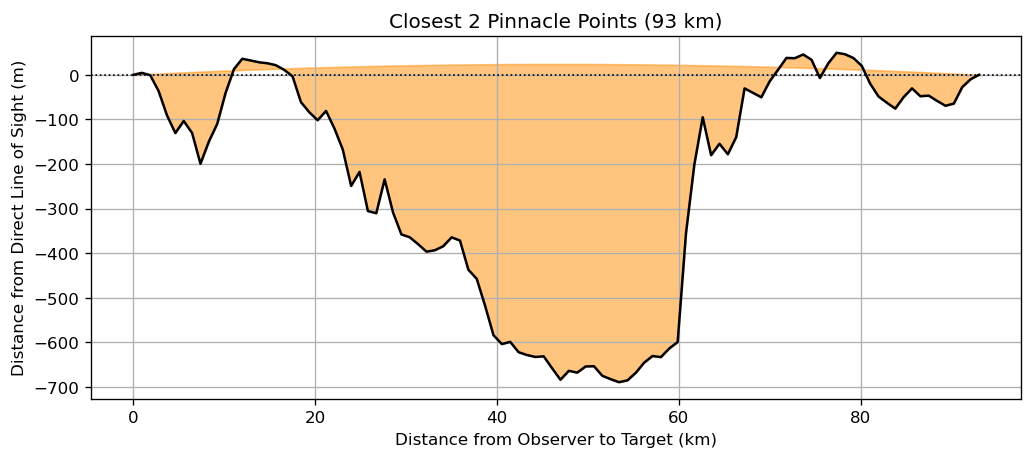

In [7]:
# finding the closest 2 pinnacle points
minPinnalceDist = 999999999
minPinnalce1 = None
minPinnalce2 = None
    
for i, pinnaclePoint1 in enumerate(pinnaclePoints.iterrows()):
    pinnaclePoint1 = pinnaclePoint1[1]
    
    for pinnaclePoint2 in pinnaclePoints[i+1:].iterrows():
        pinnaclePoint2 = pinnaclePoint2[1]
        ppDist = func.geod.line_length([pinnaclePoint1.longitude, 
                                        pinnaclePoint2.longitude], 
                                       [pinnaclePoint1.latitude, 
                                        pinnaclePoint2.latitude])
        
        if ppDist < minPinnalceDist:
            minPinnalceDist = ppDist
            minPinnalce1 = pinnaclePoint1
            minPinnalce2 = pinnaclePoint2

# testing closest pinnacle points
func.plotLosElevationProfile(minPinnalce1.latitude, minPinnalce1.longitude, 
                             minPinnalce1.elevation, 
                             minPinnalce2.latitude, minPinnalce2.longitude, 
                             minPinnalce2.elevation,
                             savePlot = True,
                             plotTitle = f'Closest 2 Pinnacle Points ({round(minPinnalceDist/1000)} km)')

In [ ]:
summitPatches = func.getSummitPatches(printInfo=False)

Higher Summits to Test Sight: 9
28.6981, 83.4894 at 8135.91 m is in view of 
27.9892, 86.9256 at 8737.79 m (2 summits tested)


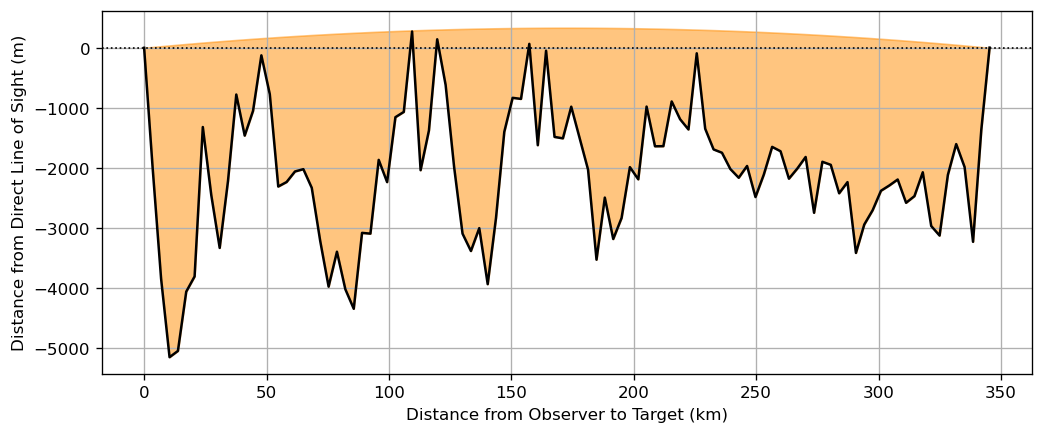

Higher Summits to Test Sight: 7
36.0242, 90.8661 at 6834.64 m is in view of 
36.4128, 87.3831 at 6981.64 m (1 summits tested)


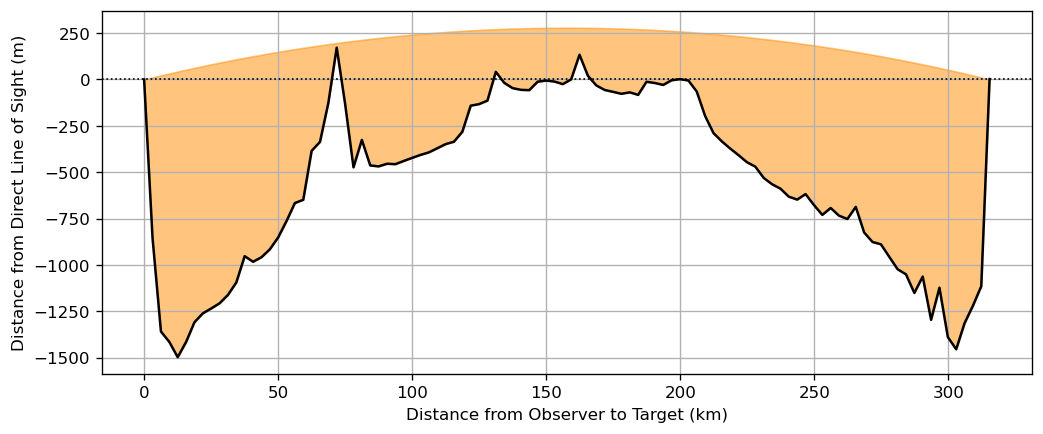

Higher Summits to Test Sight: 123
33.4964, 91.1681 at 6590.63 m is in view of 
36.0169, 90.9528 at 6611.4 m (1 summits tested)


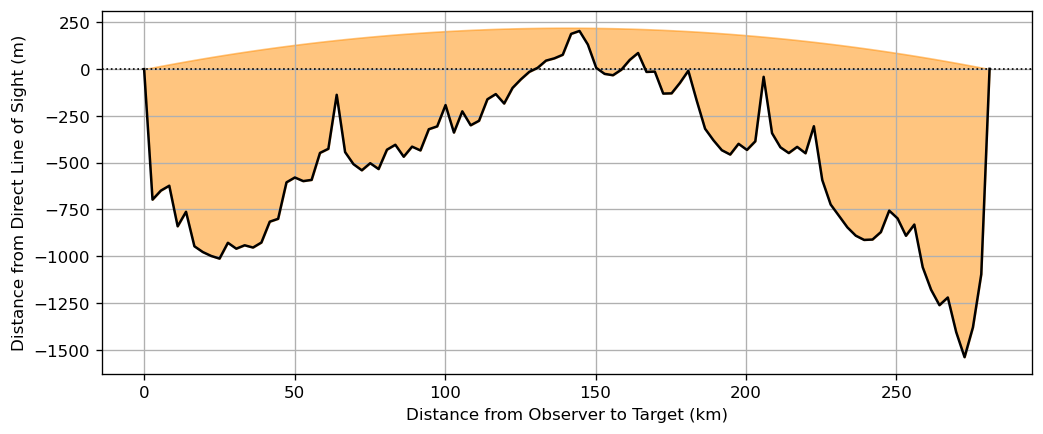

Higher Summits to Test Sight: 70
-12.2592, -75.9592 at 5870.53 m is in view of 
-10.3083, -76.8817 at 5912.44 m (1 summits tested)


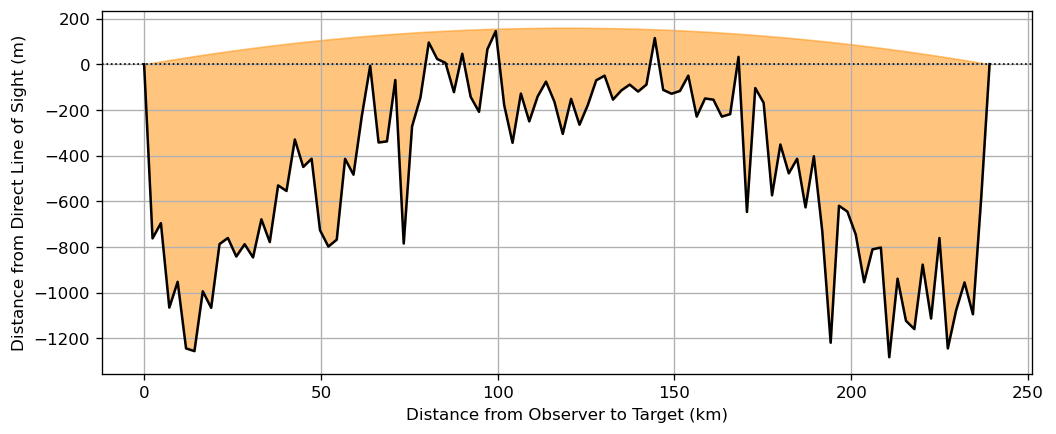

Higher Summits to Test Sight: 121
39.2514, 93.6964 at 5826.41 m is in view of 
35.6597, 94.2642 at 6047.64 m (6 summits tested)


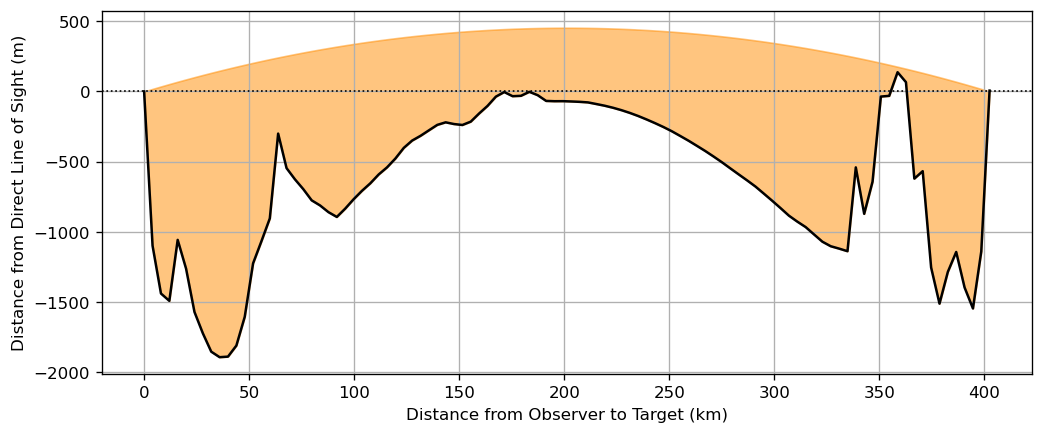

Higher Summits to Test Sight: 623
37.6928, 101.5061 at 5237.24 m is in view of 
38.2403, 98.7289 at 5294.43 m (1 summits tested)


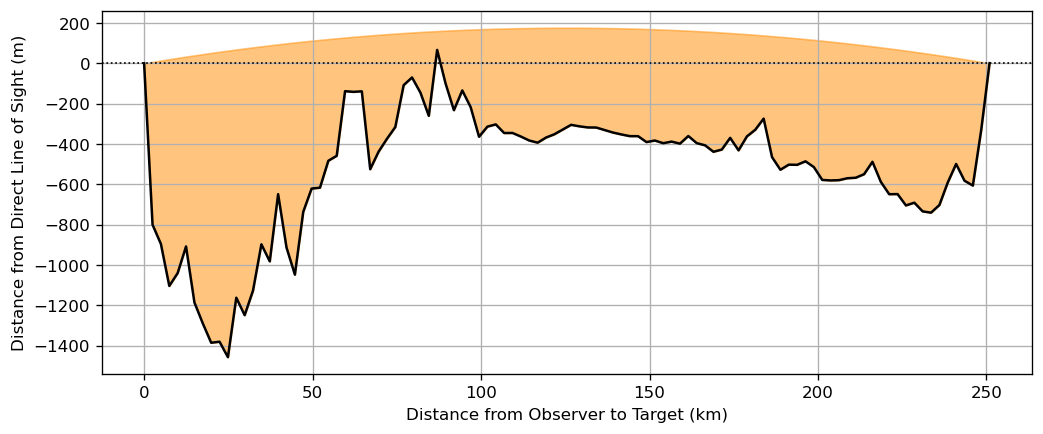

Higher Summits to Test Sight: 2
38.2669, 47.8367 at 4805.46 m is in view of 
39.7022, 44.2983 at 5111.0 m (1 summits tested)


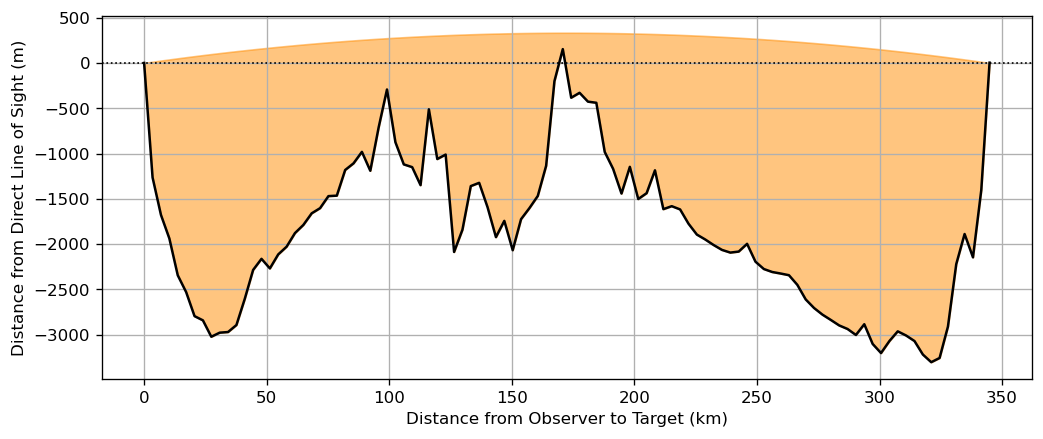

Higher Summits to Test Sight: 32
-8.8928, 147.5331 at 4024.35 m is in view of 
-6.3264, 147.0945 at 4047.43 m (1 summits tested)


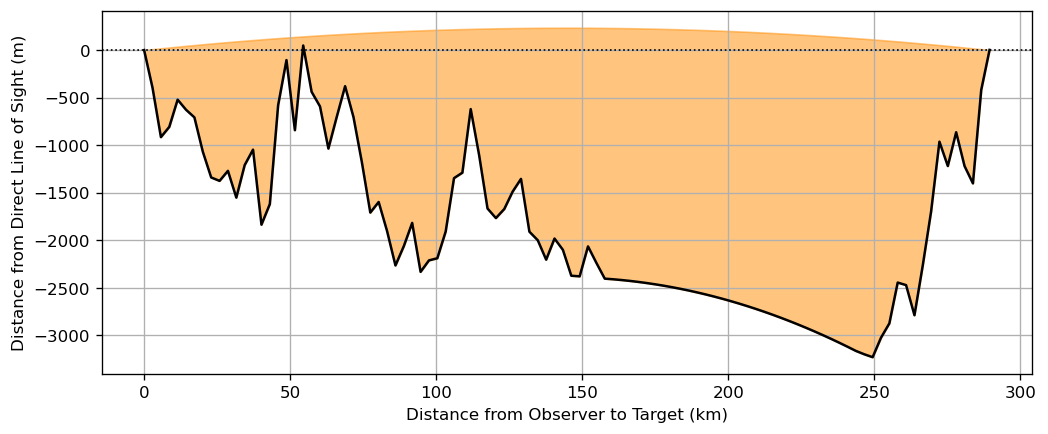

Higher Summits to Test Sight: 9
47.6089, 97.5525 at 4007.42 m is in view of 
46.6175, 93.5945 at 4206.65 m (1 summits tested)


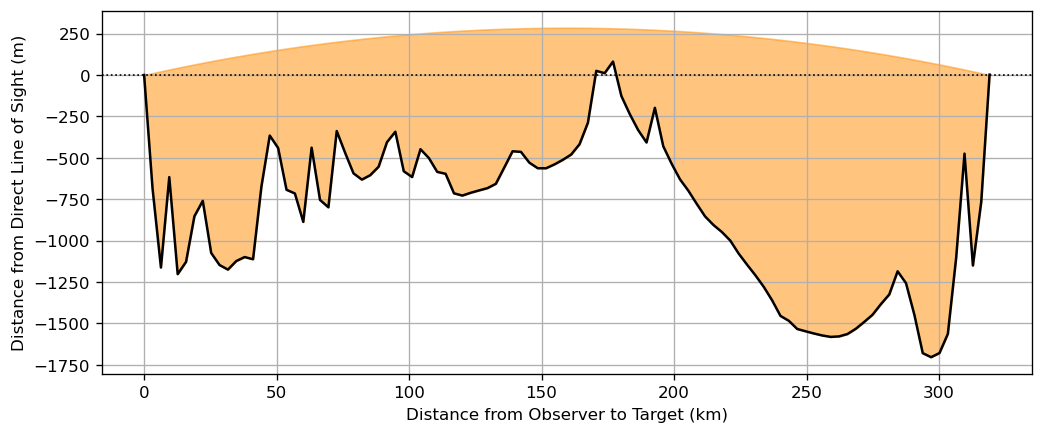

Higher Summits to Test Sight: 17
-85.7089, -128.5778 at 3885.18 m is in view of 
-85.0533, -171.3639 at 4025.02 m (3 summits tested)


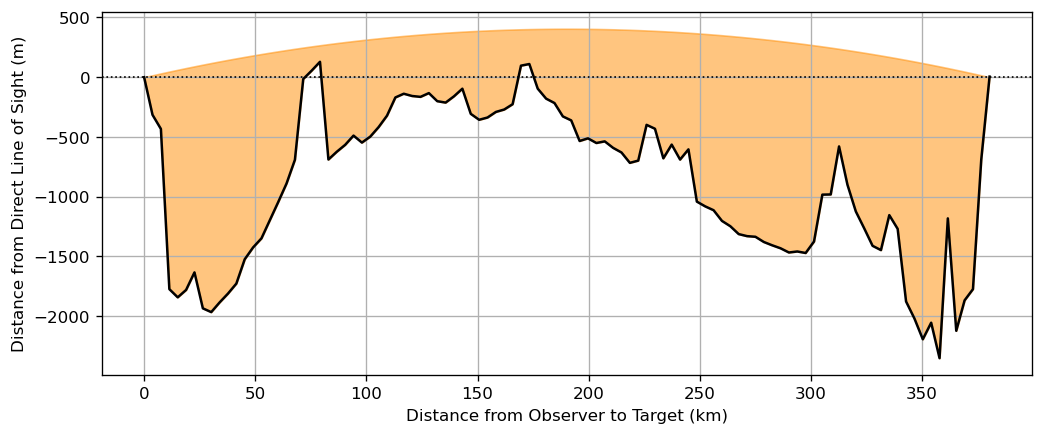

Higher Summits to Test Sight: 51
-86.2908, -158.6361 at 3857.97 m is in view of 
-85.0678, -171.2139 at 4114.94 m (3 summits tested)


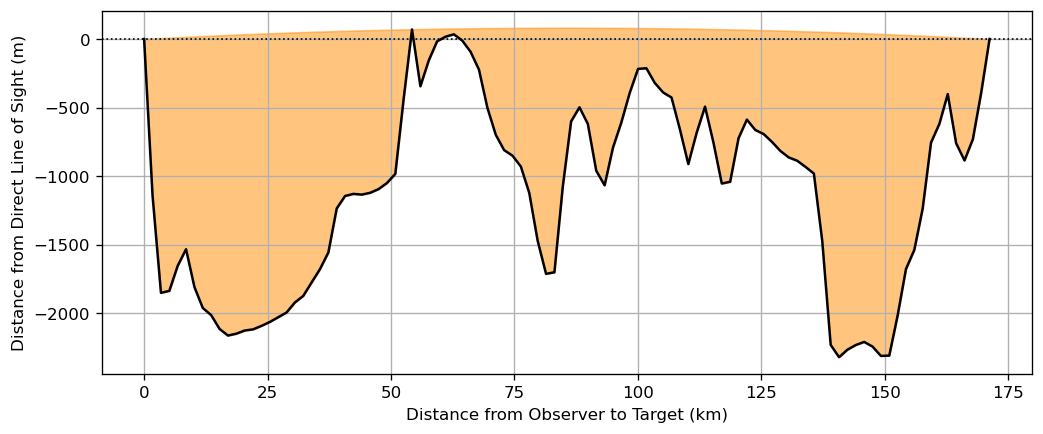

Higher Summits to Test Sight: 21
-39.6372, -71.5028 at 3745.5 m is in view of 
-37.1481, -70.0369 at 3869.78 m (2 summits tested)


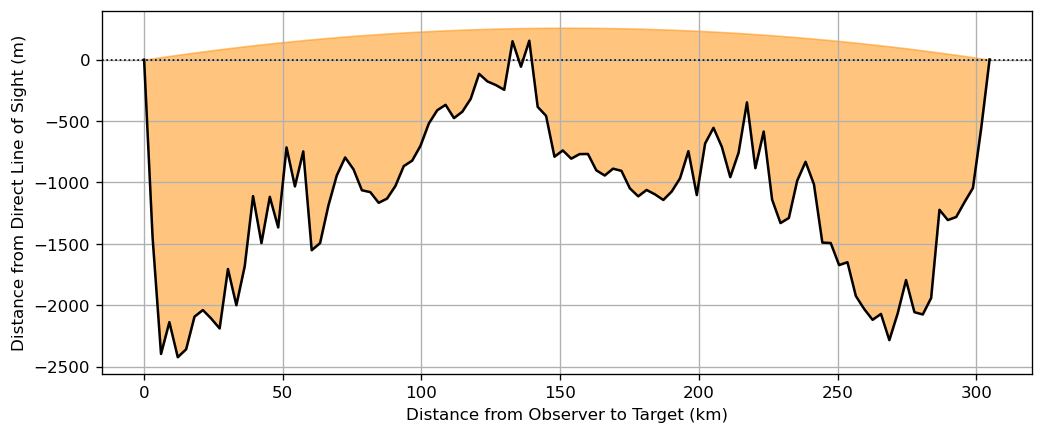

Higher Summits to Test Sight: 110
16.2147, -96.1819 at 3724.69 m is in view of 
15.1325, -92.1083 at 4085.37 m (95 summits tested)


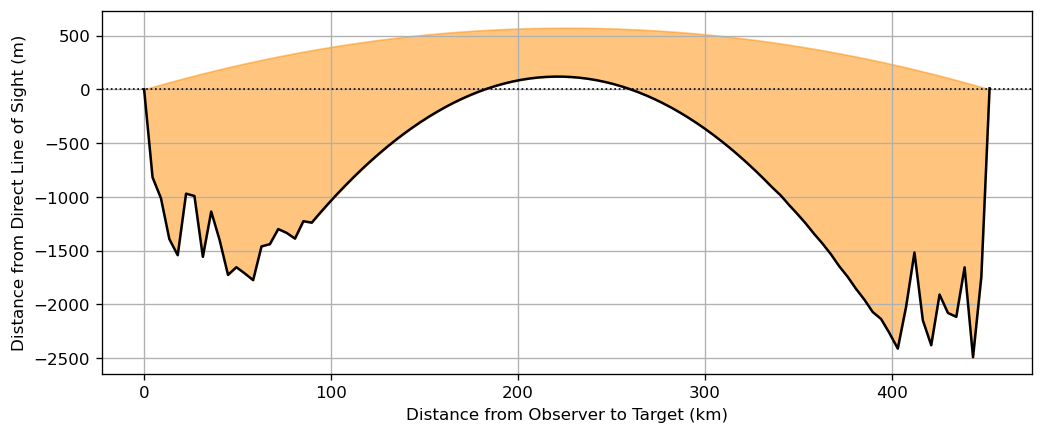

Higher Summits to Test Sight: 331
33.3743, -105.8088 at 3649.37 m is in view of 
35.7815, -105.7624 at 3691.13 m (1 summits tested)


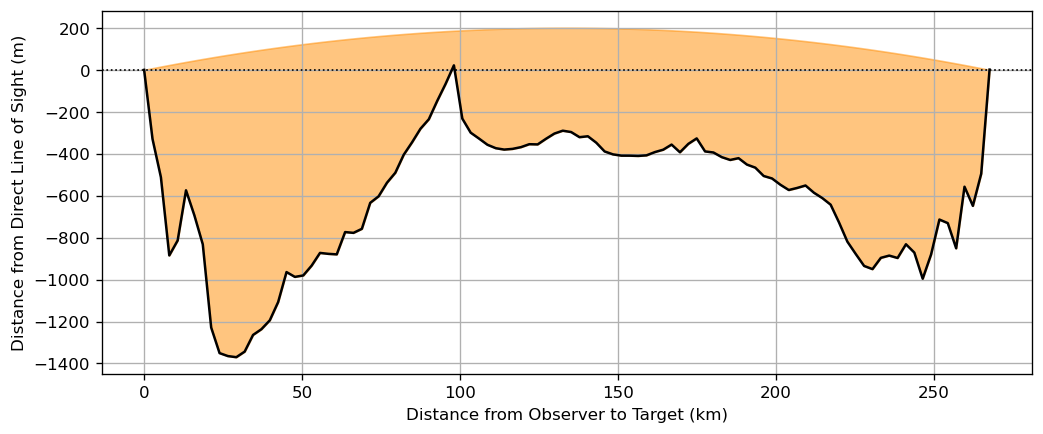

Higher Summits to Test Sight: 1852
30.2625, 67.3014 at 3569.54 m is in view of 
32.5244, 66.4103 at 3786.2 m (1 summits tested)


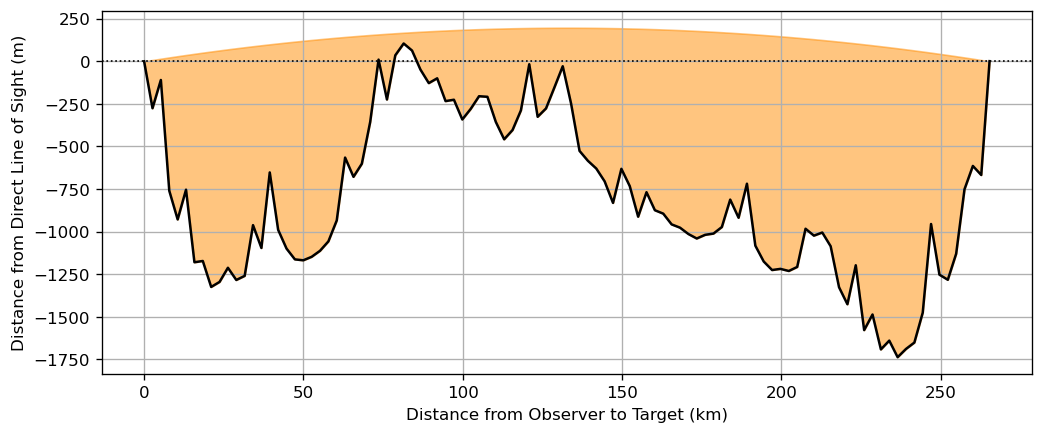

Higher Summits to Test Sight: 5
50.87, -115.6511 at 3556.13 m is in view of 
52.2472, -117.9578 at 3622.13 m (4 summits tested)


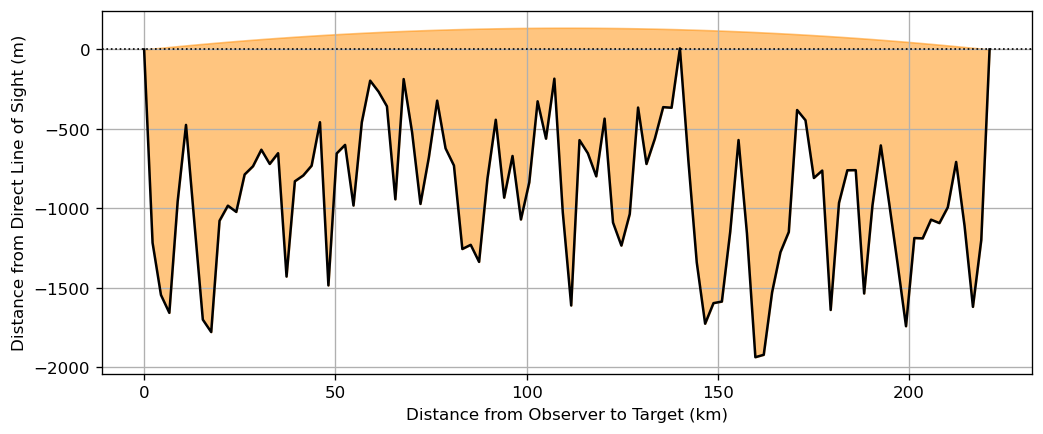

Higher Summits to Test Sight: 17
-73.4425, -126.7508 at 3195.14 m is in view of 
-76.5089, -125.8583 at 3334.59 m (1 summits tested)


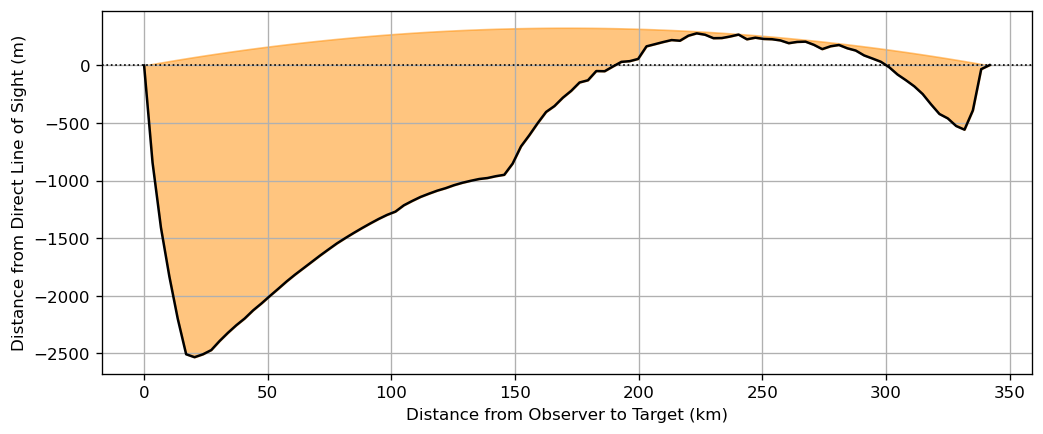

Higher Summits to Test Sight: 126
3.9461, 32.9103 at 3179.08 m is in view of 
1.17, 34.5306 at 4205.65 m (13 summits tested)


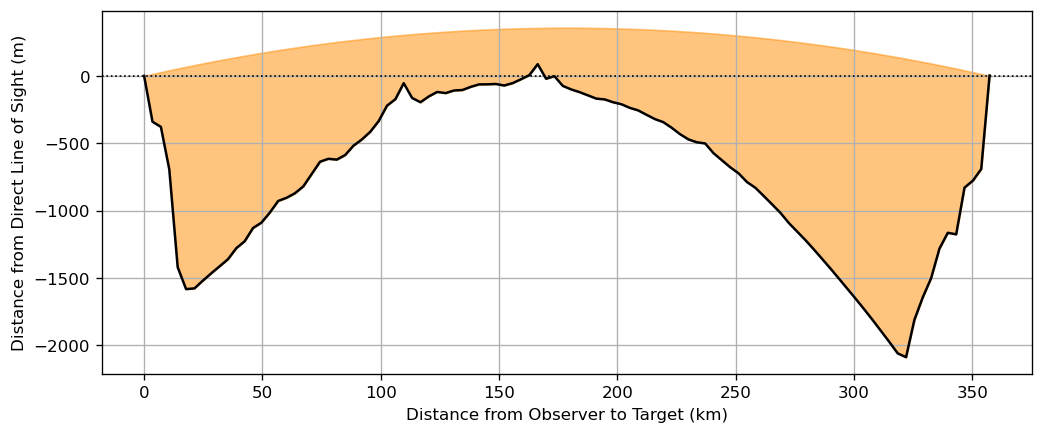

Higher Summits to Test Sight: 368
41.1, 33.8633 at 2582.77 m is in view of 
38.5317, 35.4469 at 3890.73 m (10 summits tested)


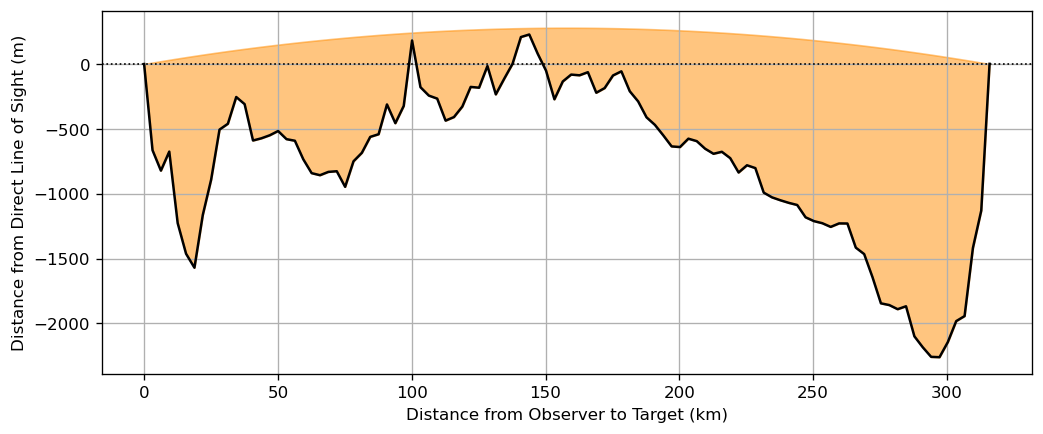

Higher Summits to Test Sight: 42
45.5853, 24.5581 at 2526.52 m is in view of 
42.1967, 23.6031 at 2784.72 m (4 summits tested)


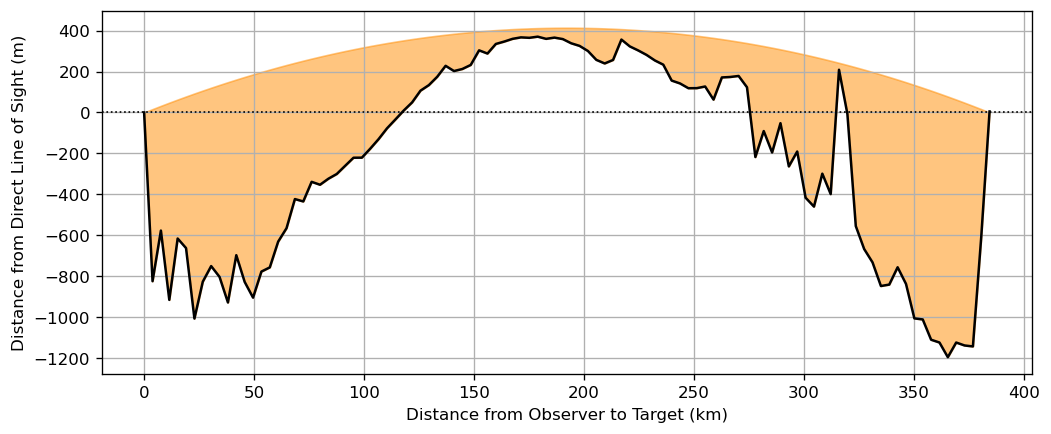

Higher Summits to Test Sight: 12
50.5742, 134.5939 at 2254.72 m is in view of 
52.4839, 134.8275 at 2262.35 m (1 summits tested)


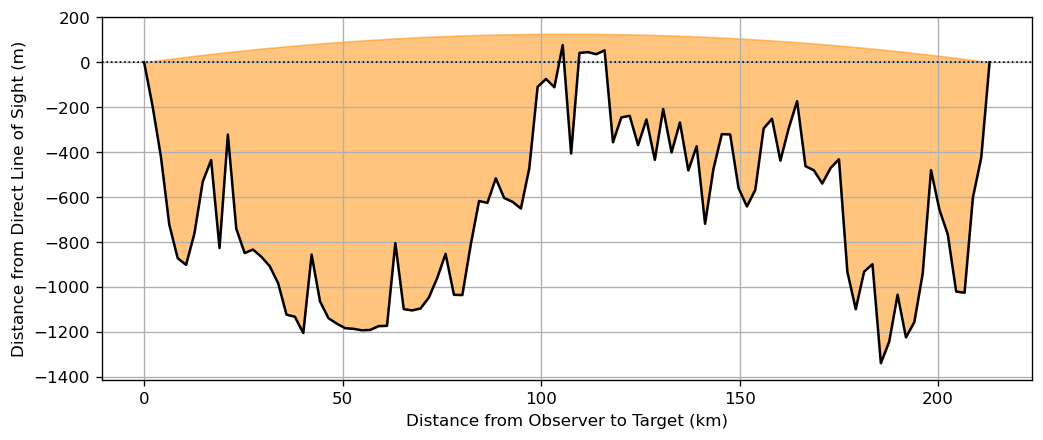

Higher Summits to Test Sight: 106
20.7456, 36.8392 at 2180.78 m is in view of 
21.1481, 40.1825 at 2331.75 m (1 summits tested)


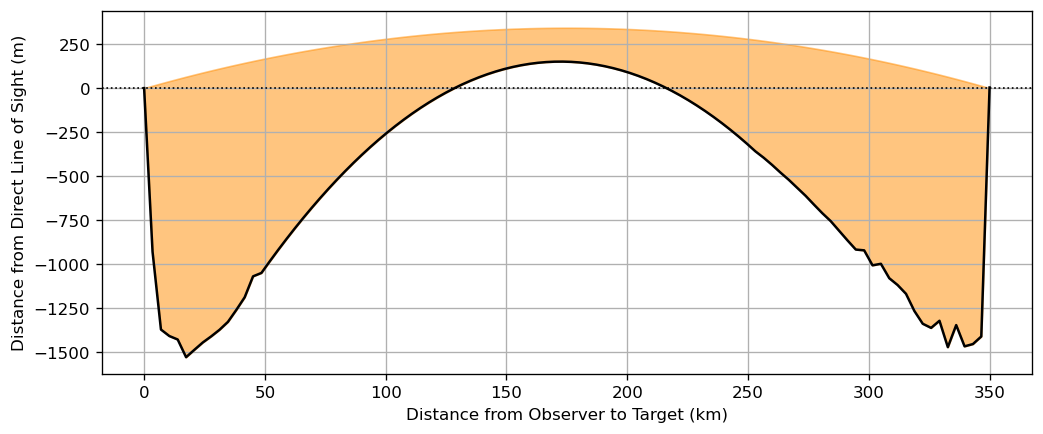

Higher Summits to Test Sight: 42
-71.0136, 65.1467 at 2176.7 m is in view of 
-70.1944, 64.8 at 2208.16 m (1 summits tested)


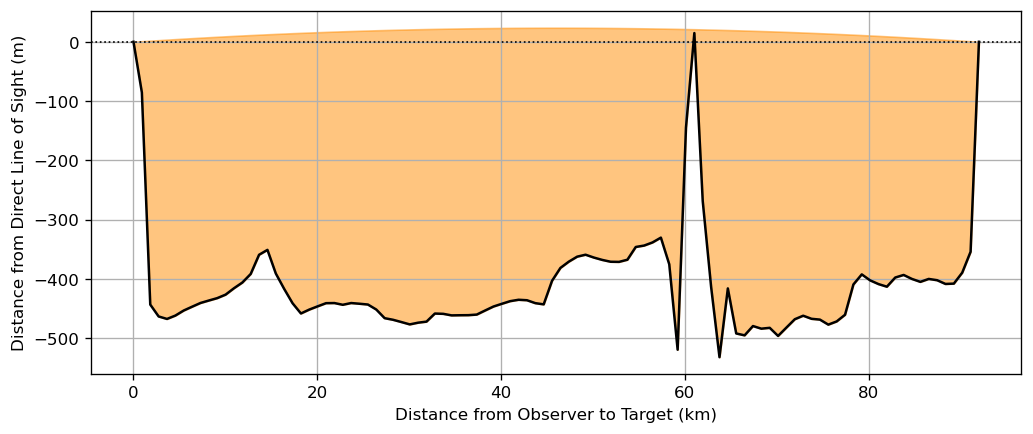

Higher Summits to Test Sight: 45
79.9256, -92.3075 at 2082.1 m is in view of 
78.7847, -79.6675 at 2156.98 m (4 summits tested)


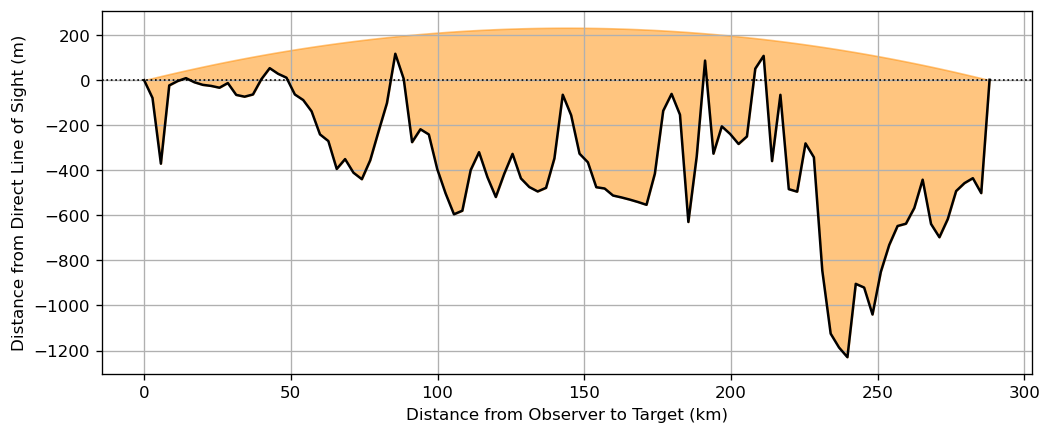

Higher Summits to Test Sight: 76
23.5392, -109.9544 at 2078.07 m is in view of 
25.7464, -107.6414 at 2096.11 m (1 summits tested)


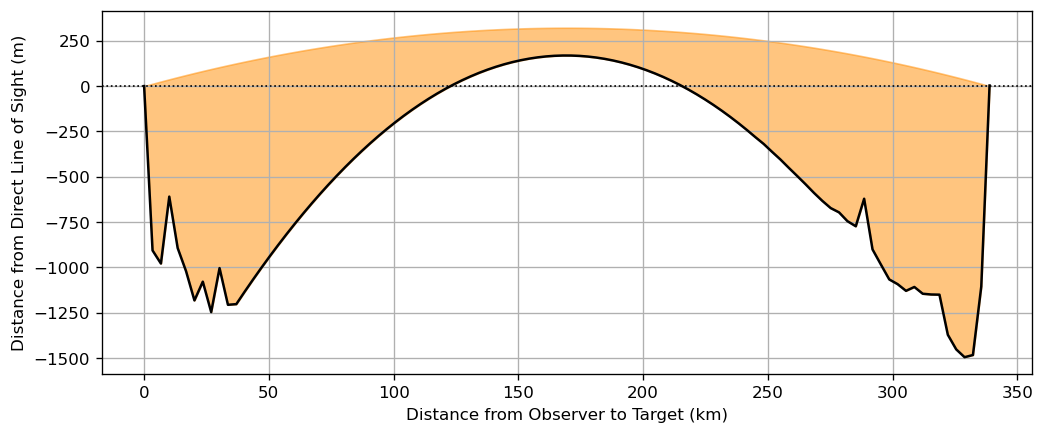

Higher Summits to Test Sight: 337
9.9658, 45.0283 at 2001.23 m is in view of 
10.67, 47.095 at 2107.67 m (5 summits tested)


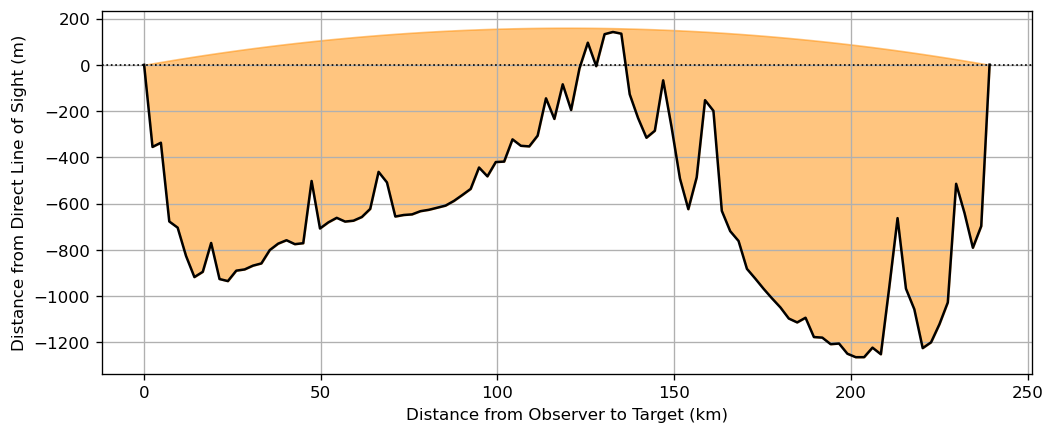

Higher Summits to Test Sight: 65
61.4864, 155.3145 at 1997.79 m is in view of 
61.6997, 151.0633 at 1998.43 m (2 summits tested)


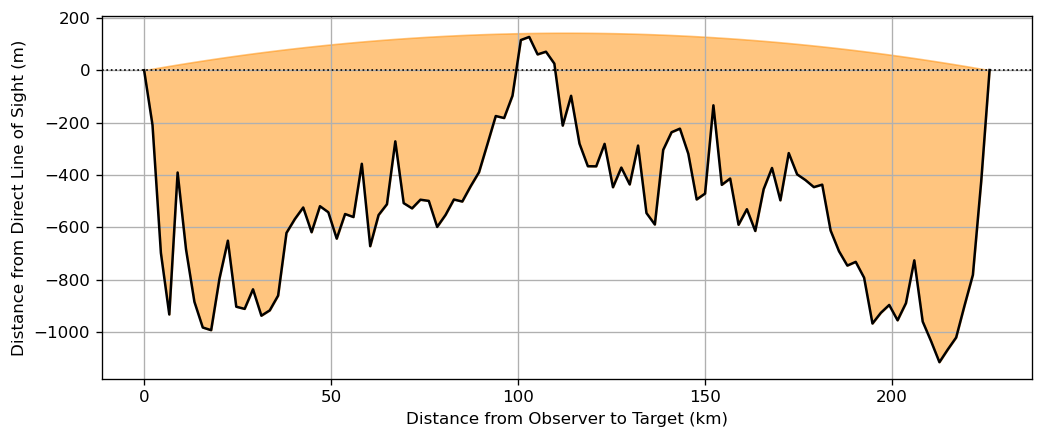

Higher Summits to Test Sight: 1
19.0136, 8.6014 at 1983.72 m is in view of 
17.8392, 8.7206 at 2001.37 m (1 summits tested)


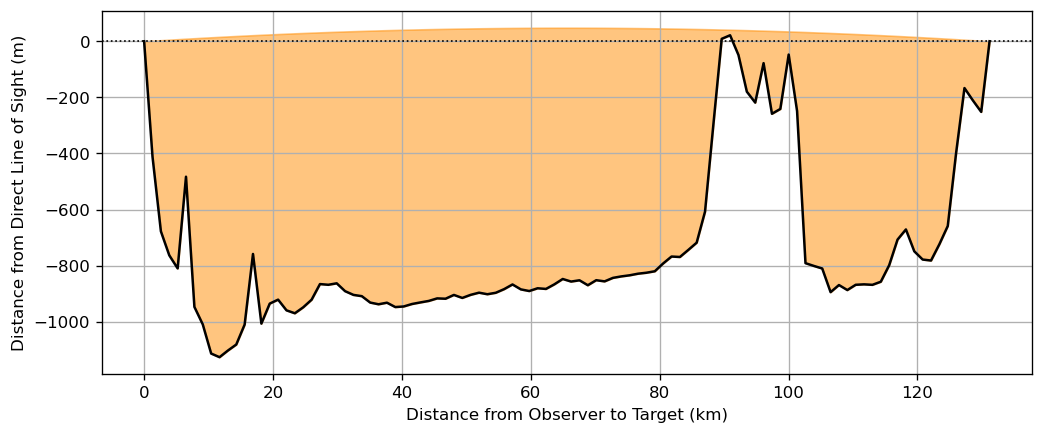

Higher Summits to Test Sight: 18
35.8744, 1.6322 at 1974.9 m is in view of 
36.4608, 4.0372 at 2155.35 m (5 summits tested)


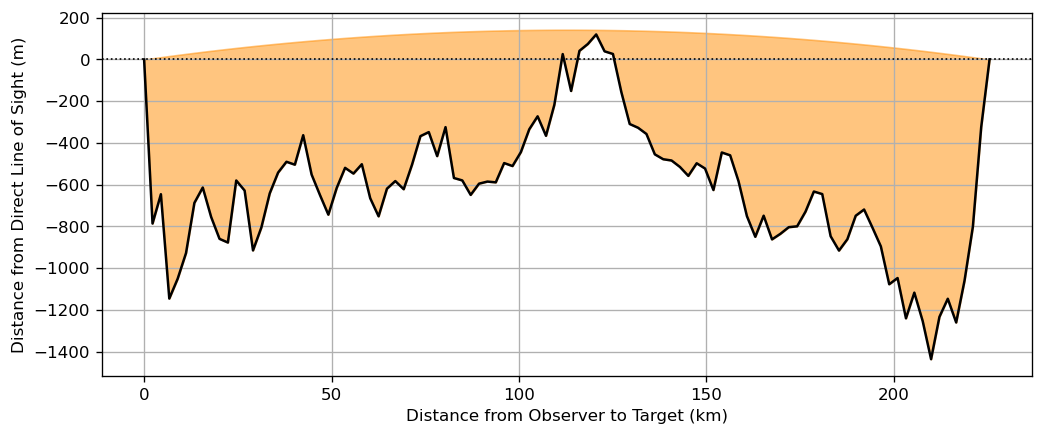

Higher Summits to Test Sight: 3
27.47, -112.5919 at 1946.8 m is in view of 
29.8186, -110.3519 at 2190.88 m (2 summits tested)


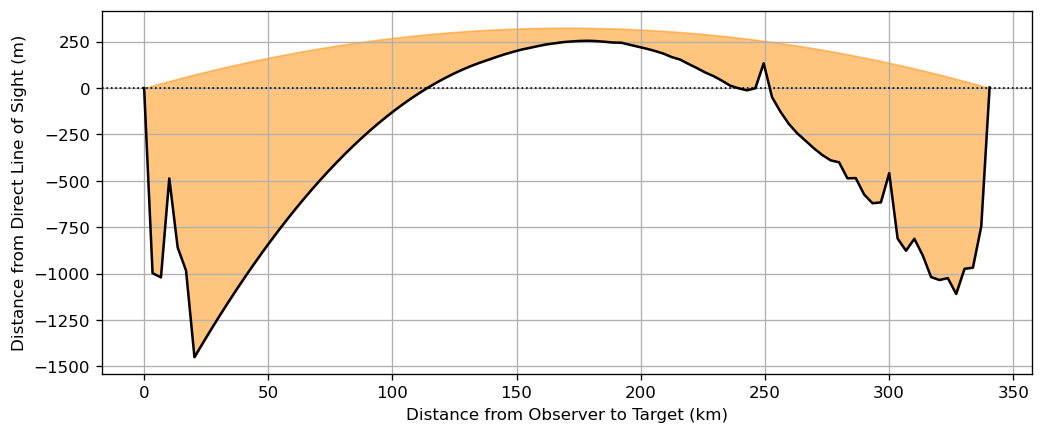

Higher Summits to Test Sight: 2042
53.7269, 117.5575 at 1909.29 m is in view of 
55.7006, 116.4058 at 1955.9 m (4 summits tested)


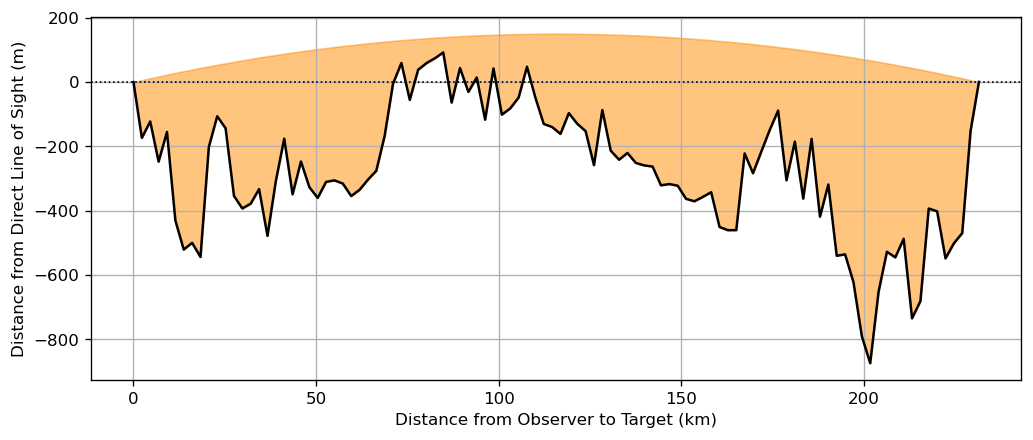

Higher Summits to Test Sight: 853
-11.5231, 31.5922 at 1878.98 m is in view of 
-11.7056, 33.7614 at 1908.58 m (28 summits tested)


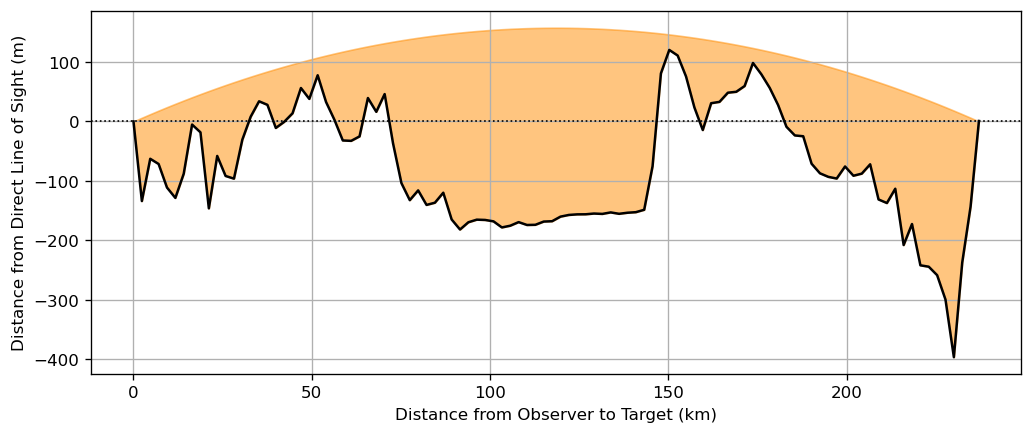

Higher Summits to Test Sight: 48
30.1347, 118.1642 at 1832.84 m is in view of 
27.8806, 117.7828 at 2133.02 m (12 summits tested)


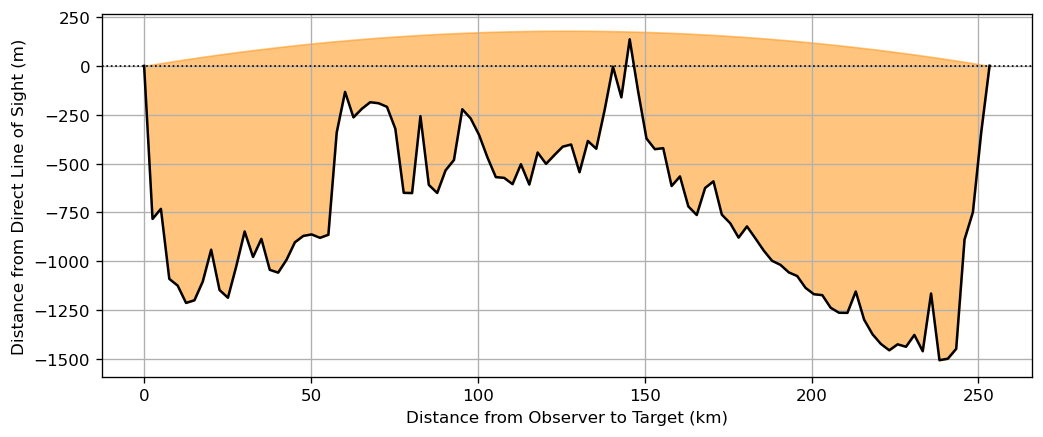

Higher Summits to Test Sight: 1
65.3378, 165.5622 at 1781.07 m is in view of 
66.0247, 163.2383 at 1812.03 m (1 summits tested)


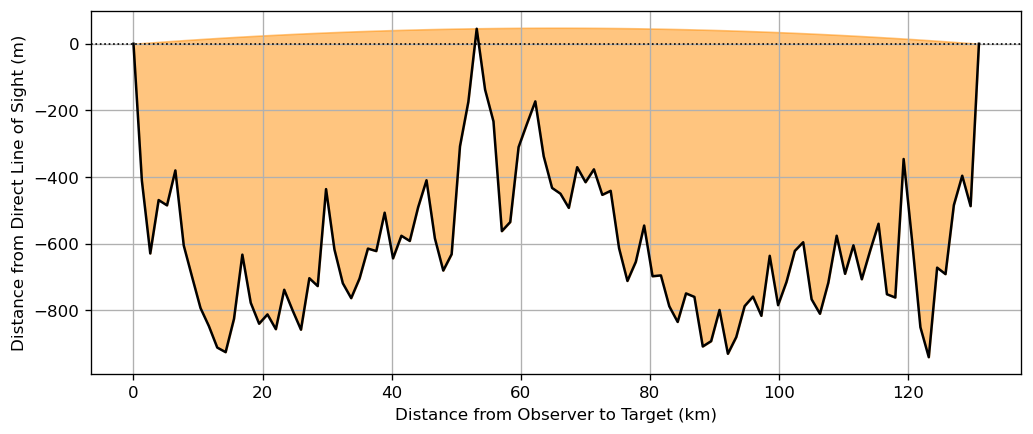

Higher Summits to Test Sight: 67
44.3531, 146.2533 at 1760.21 m is in view of 
43.7269, 143.0592 at 1784.61 m (2 summits tested)


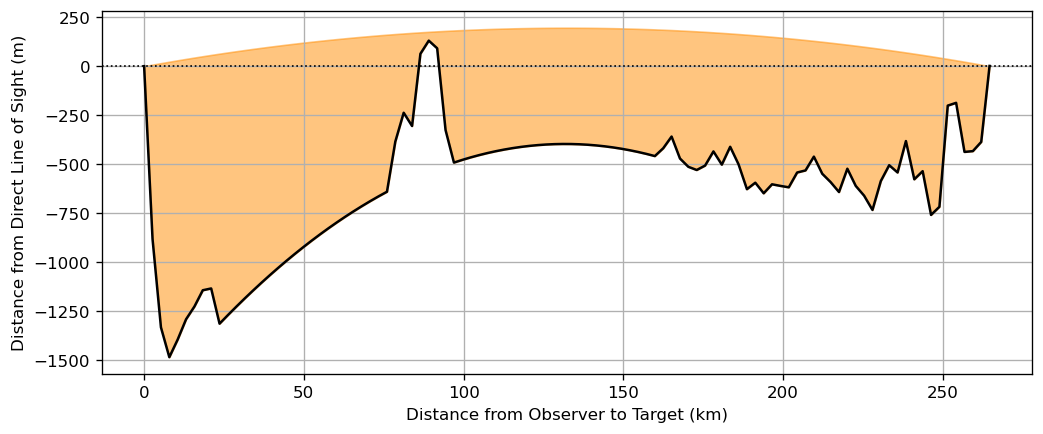

Higher Summits to Test Sight: 676
30.3942, 35.4925 at 1733.16 m is in view of 
28.4208, 34.1583 at 1749.75 m (346 summits tested)


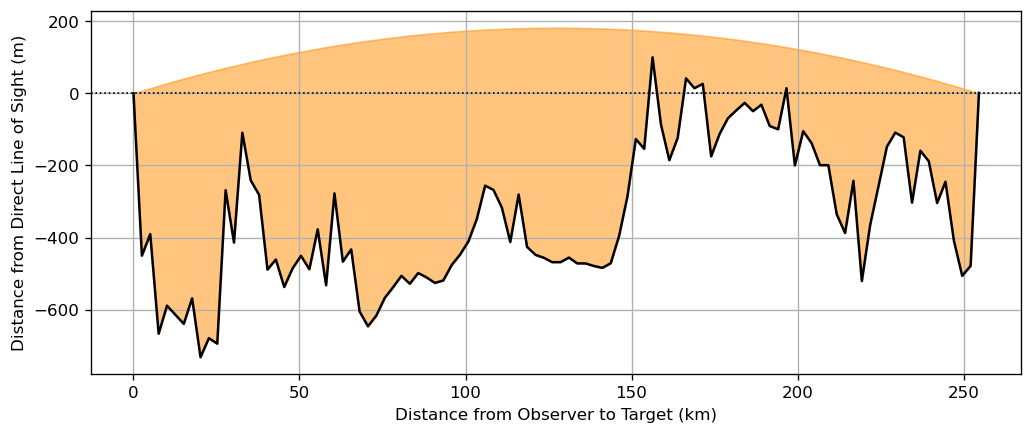

Higher Summits to Test Sight: 19
-37.9169, 178.06 at 1730.87 m is in view of 
-39.1325, 175.6456 at 1898.62 m (6 summits tested)


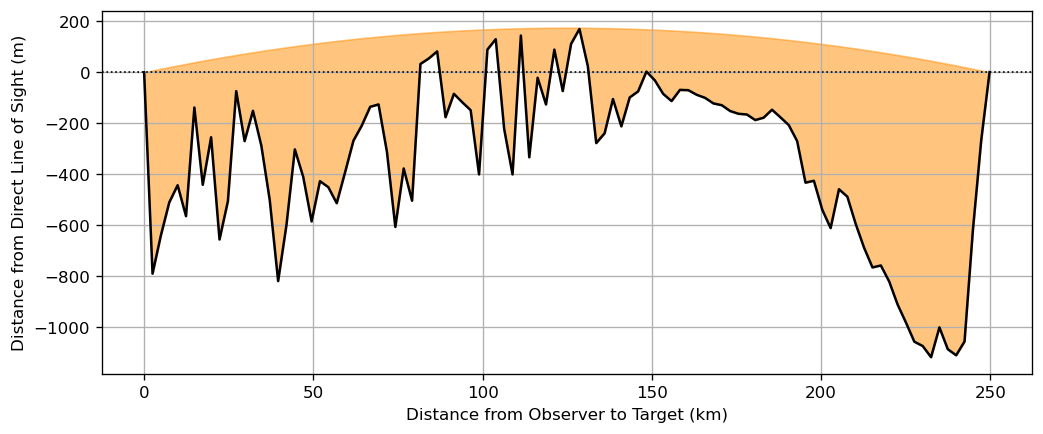

Higher Summits to Test Sight: 1
47.5422, 120.48 at 1729.63 m is in view of 
47.0578, 120.5219 at 1747.47 m (1 summits tested)


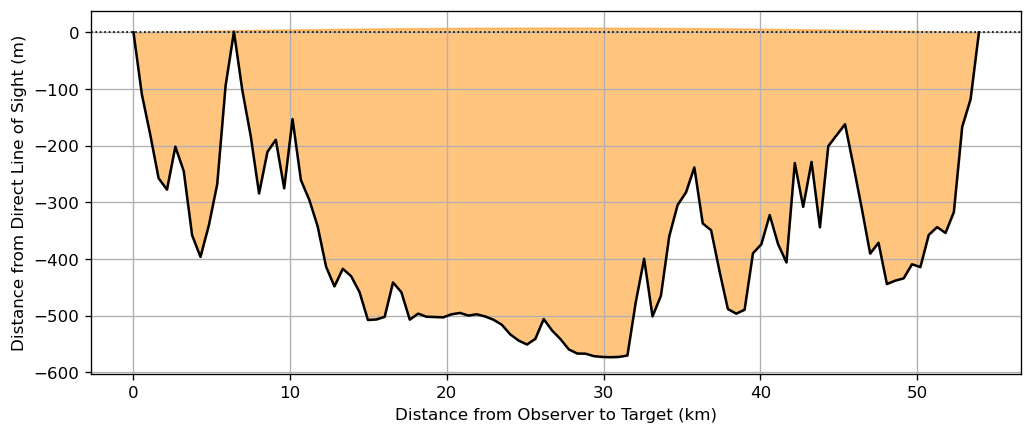

Higher Summits to Test Sight: 978
67.9933, -136.585 at 1703.66 m is in view of 
69.1753, -140.9244 at 1764.6 m (2 summits tested)


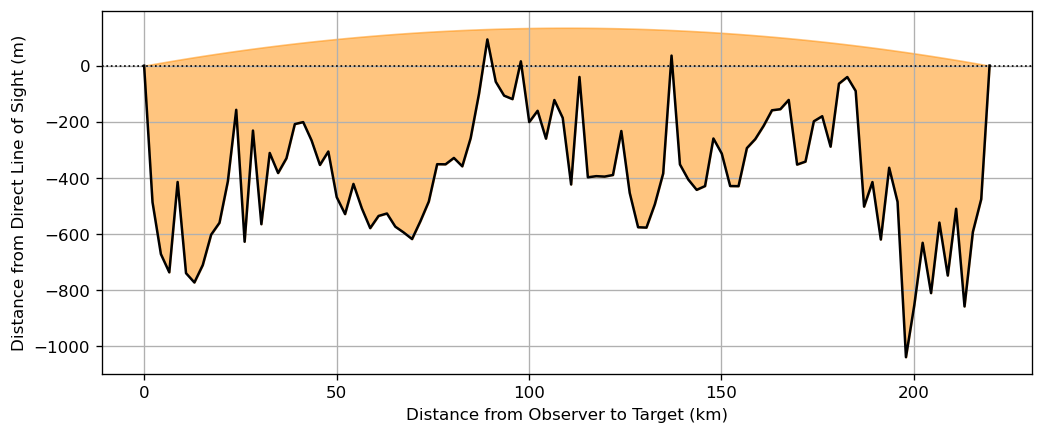

Higher Summits to Test Sight: 2
50.8517, 143.1422 at 1605.34 m is in view of 
50.3319, 139.2364 at 1623.03 m (2 summits tested)


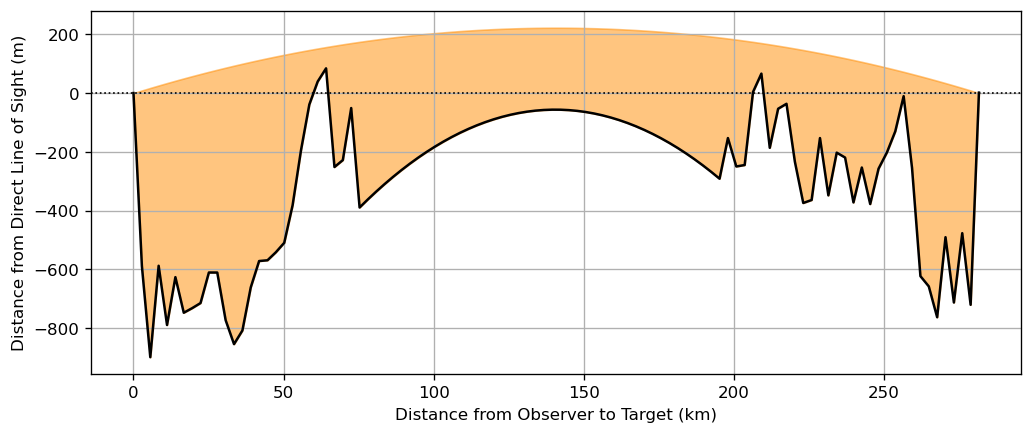

Higher Summits to Test Sight: 17
44.6128, 34.2428 at 1544.48 m is in view of 
41.8561, 33.8858 at 1652.55 m (1 summits tested)


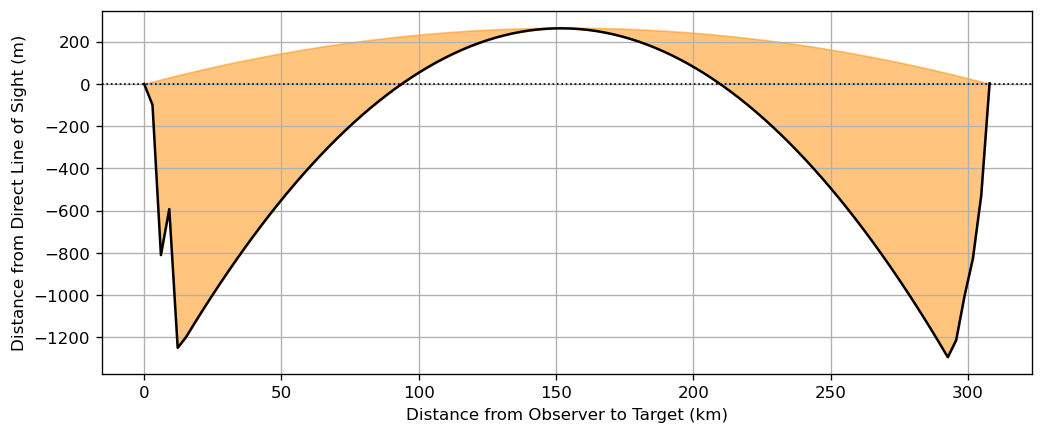

Higher Summits to Test Sight: 52
36.2561, 117.1056 at 1531.93 m is in view of 
37.4394, 114.0228 at 1790.67 m (4 summits tested)


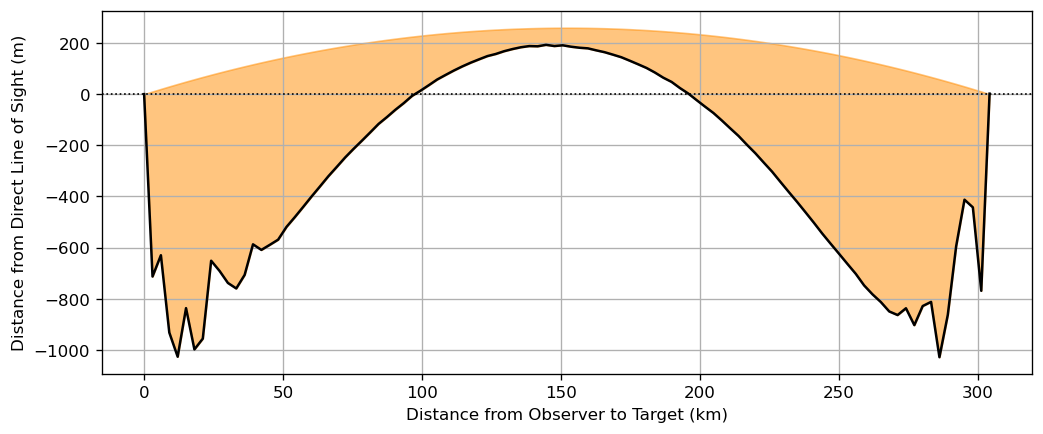

Higher Summits to Test Sight: 6473
43.0836, 110.0144 at 1436.42 m is in view of 
41.9578, 109.7808 at 1592.44 m (21 summits tested)


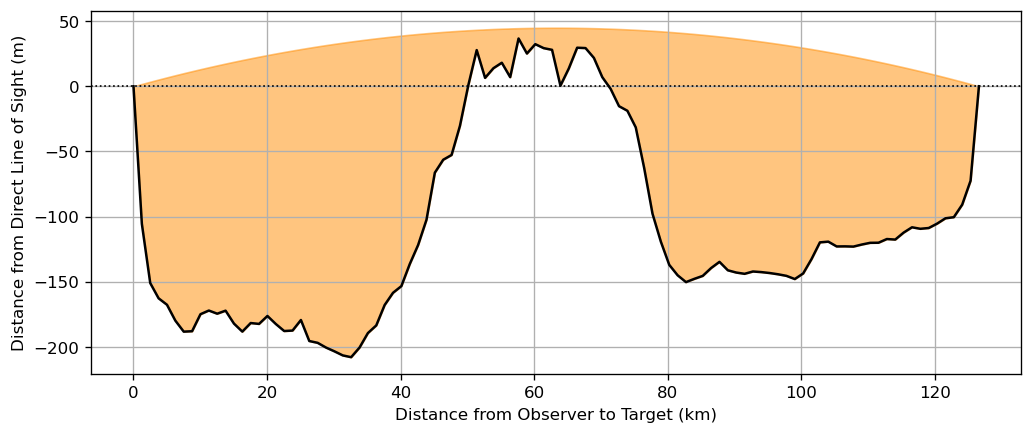

Higher Summits to Test Sight: 328
23.9639, 86.1286 at 1380.91 m is in view of 
27.7333, 86.6122 at 6499.72 m (44 summits tested)


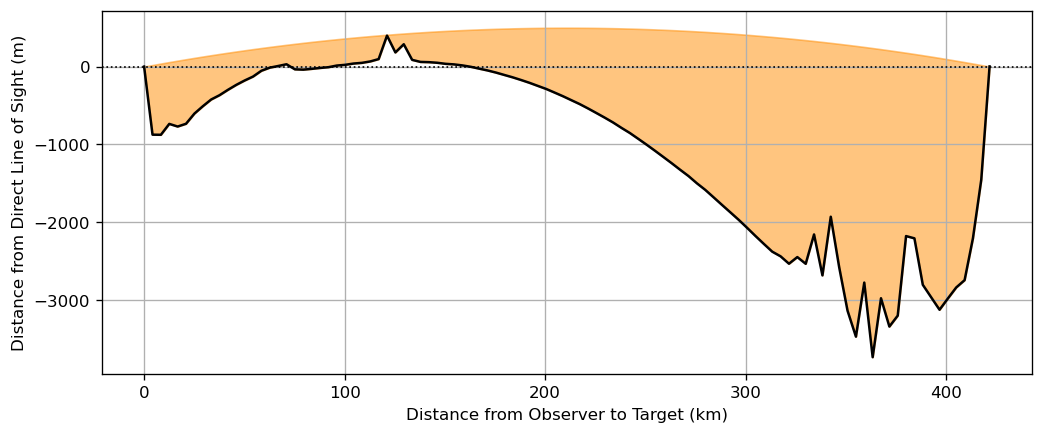

Higher Summits to Test Sight: 1043
-22.6322, 44.1675 at 1348.84 m is in view of 
-23.8269, 45.6356 at 1399.29 m (2 summits tested)


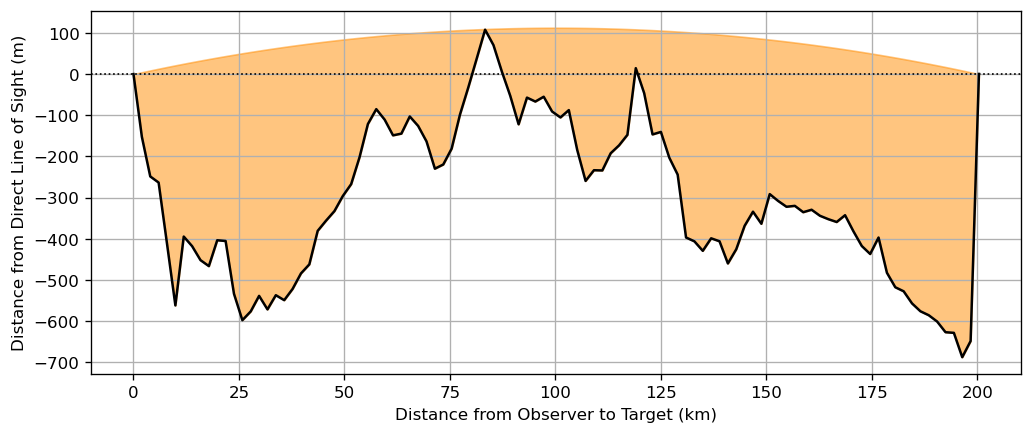

Higher Summits to Test Sight: 128
-23.9861, -51.1114 at 1303.29 m is in view of 
-25.2133, -51.2322 at 1326.0 m (3 summits tested)


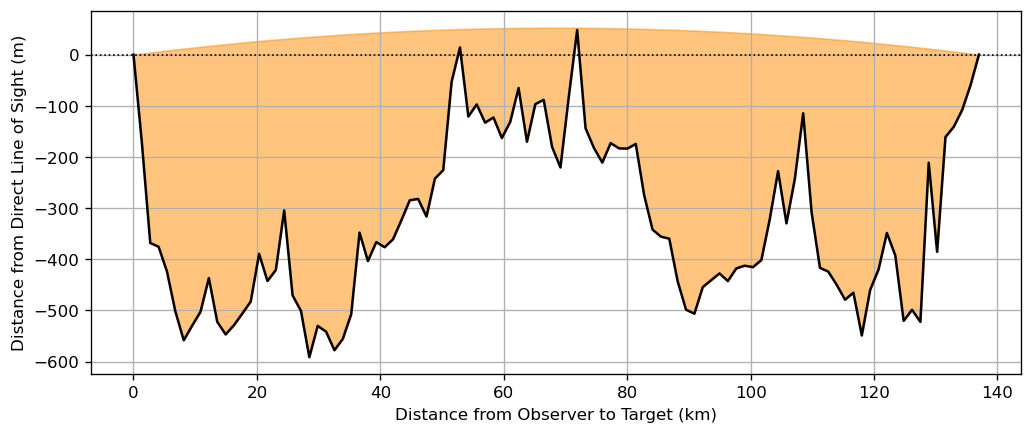

Higher Summits to Test Sight: 75
-16.5536, -40.3817 at 1211.66 m is in view of 
-18.3636, -41.3353 at 1410.44 m (12 summits tested)


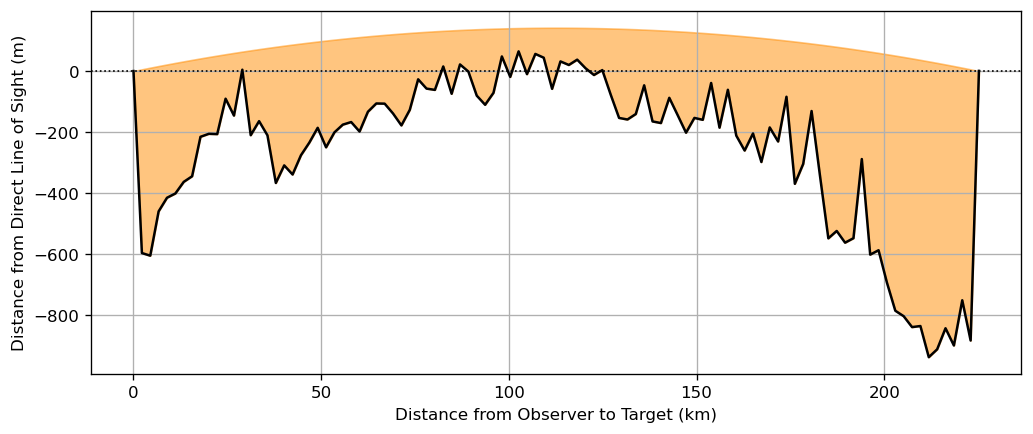

Higher Summits to Test Sight: 325
23.865, 46.4414 at 1174.04 m is in view of 
23.4756, 45.1555 at 1192.74 m (7 summits tested)


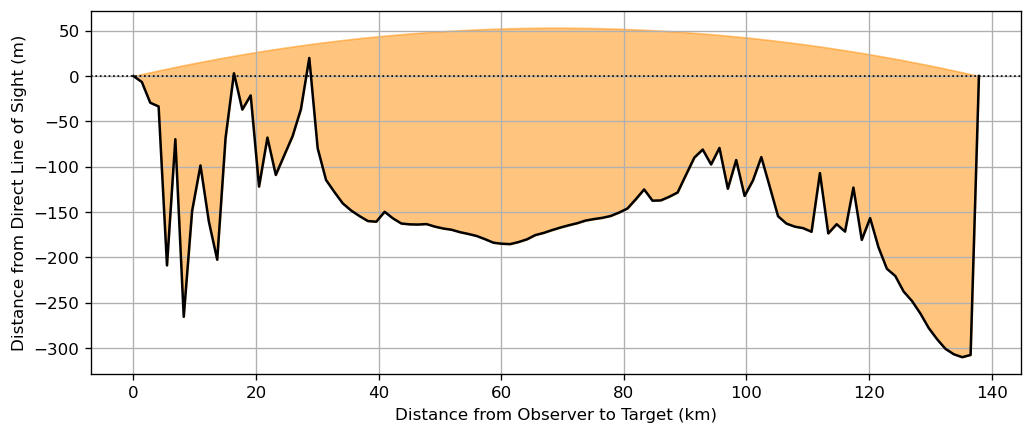

Higher Summits to Test Sight: 21
47.3094, -70.8322 at 1169.28 m is in view of 
45.9441, -69.0018 at 1210.06 m (3 summits tested)


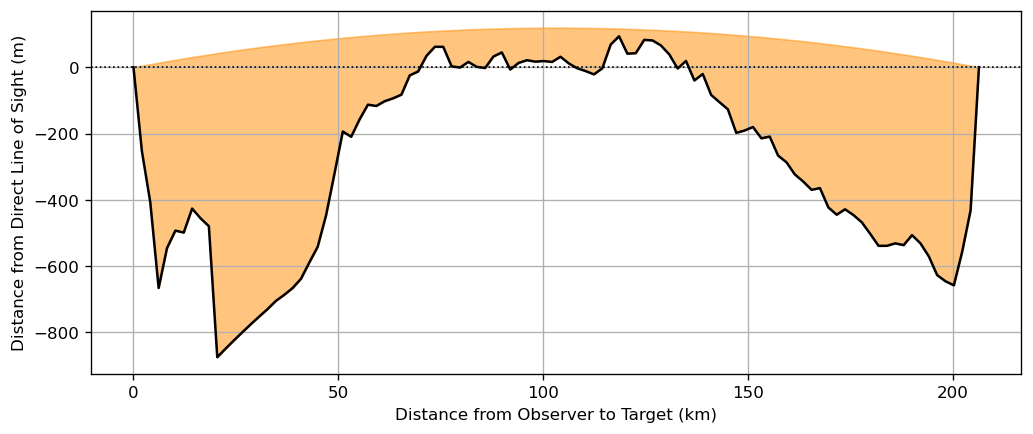

Higher Summits to Test Sight: 2
51.7997, 10.615 at 1141.76 m is in view of 
50.4289, 12.9542 at 1220.28 m (1 summits tested)


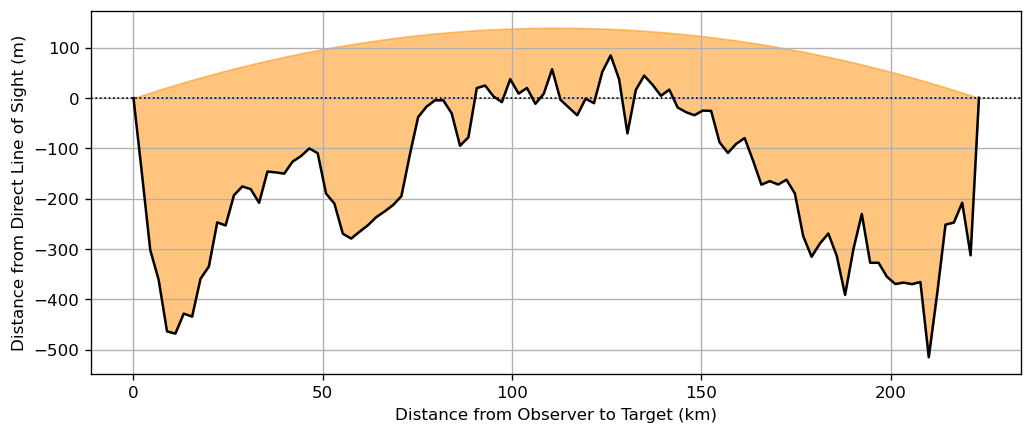

Higher Summits to Test Sight: 143
47.1608, 72.675 at 1132.33 m is in view of 
47.4372, 74.8461 at 1212.22 m (1 summits tested)


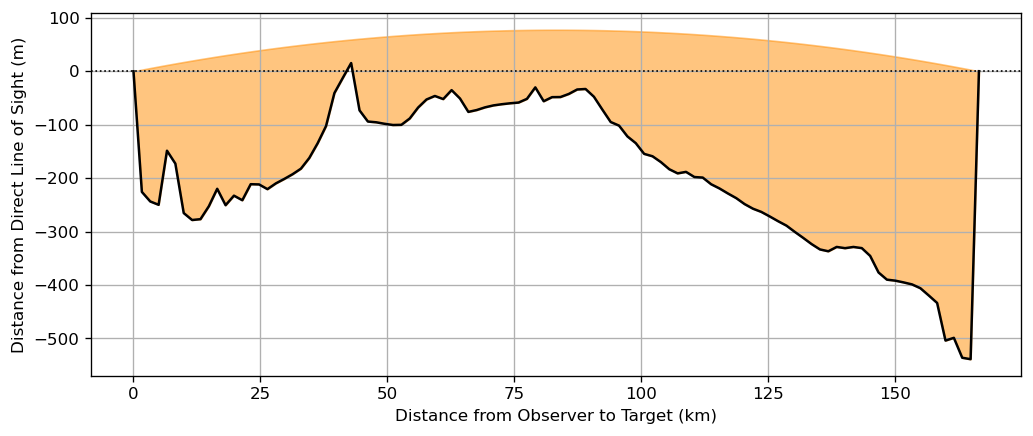

Higher Summits to Test Sight: 1
71.0975, -179.3542 at 1090.63 m is in view of 
69.1581, 177.3367 at 1091.26 m (1 summits tested)


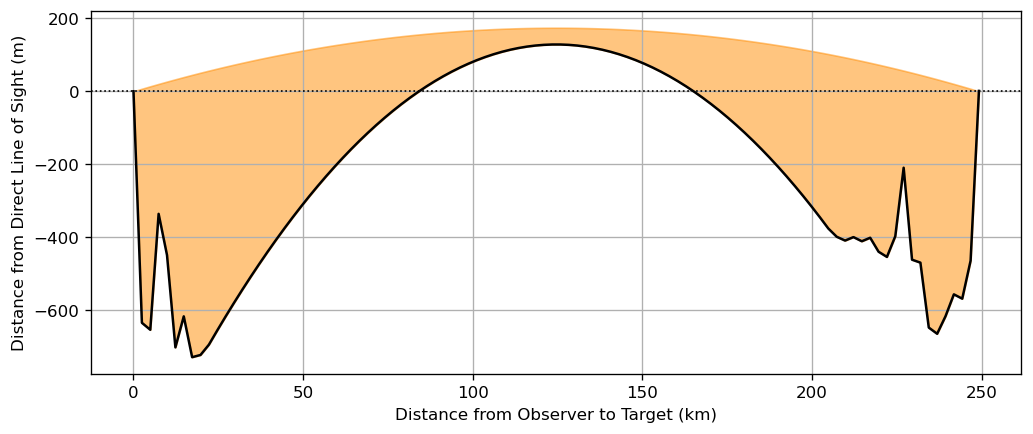

Higher Summits to Test Sight: 9
-14.2328, -169.4544 at 969.9 m is in view of 
-13.9203, -171.6597 at 1042.81 m (1 summits tested)


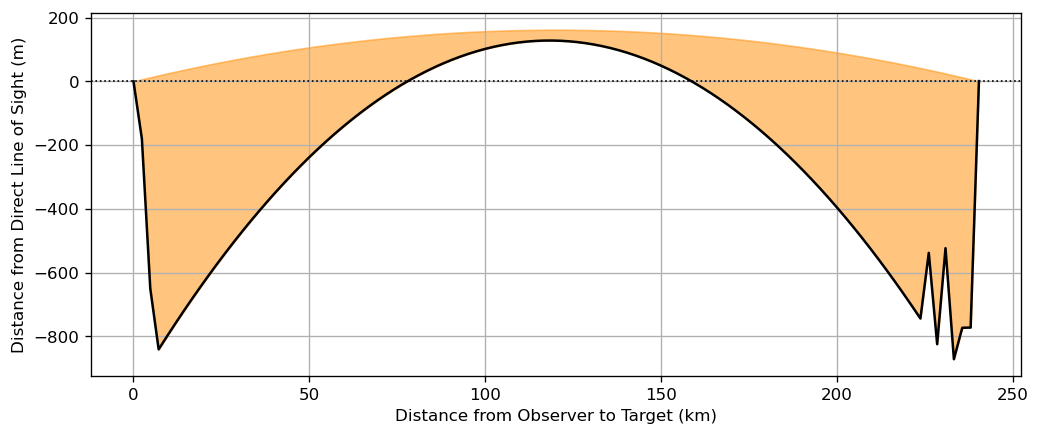

Higher Summits to Test Sight: 72
51.2164, 73.2875 at 896.12 m is in view of 
50.2014, 74.8631 at 1047.05 m (1 summits tested)


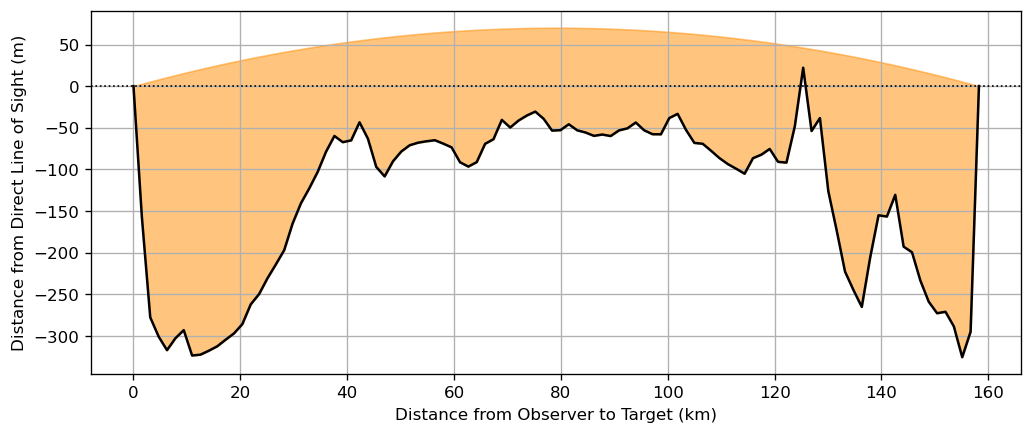

Higher Summits to Test Sight: 187
-23.3319, 129.3647 at 885.34 m is in view of 
-24.6342, 129.6105 at 1006.84 m (7 summits tested)


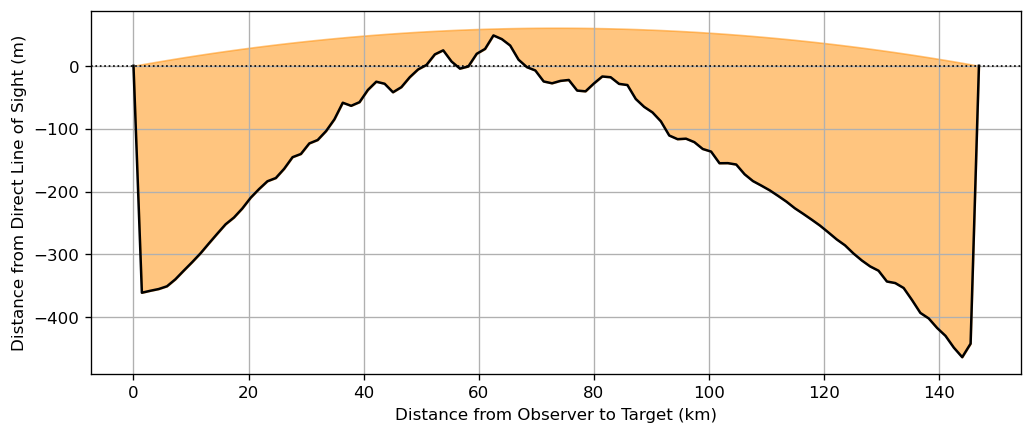

Higher Summits to Test Sight: 37
-7.1219, 128.6733 at 868.42 m is in view of 
-8.4828, 127.1906 at 889.0 m (1 summits tested)


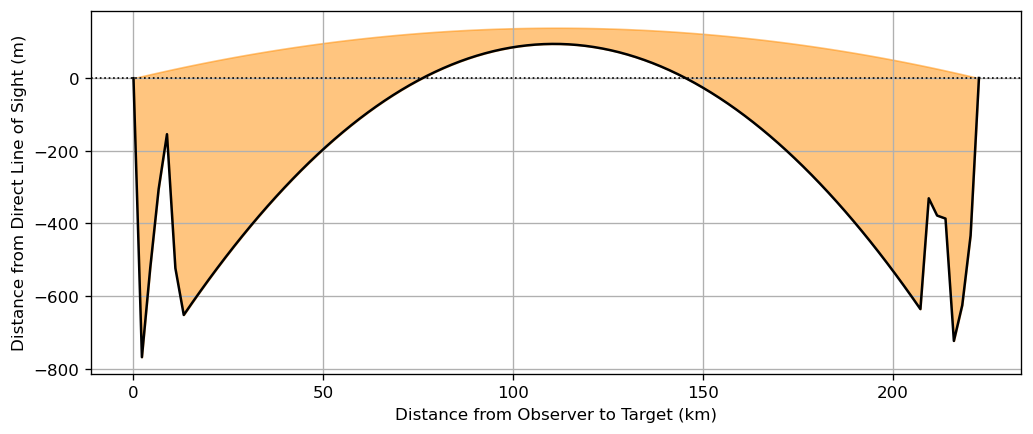

Higher Summits to Test Sight: 83
25.8033, 16.6683 at 842.82 m is in view of 
26.8272, 17.3331 at 847.37 m (1 summits tested)


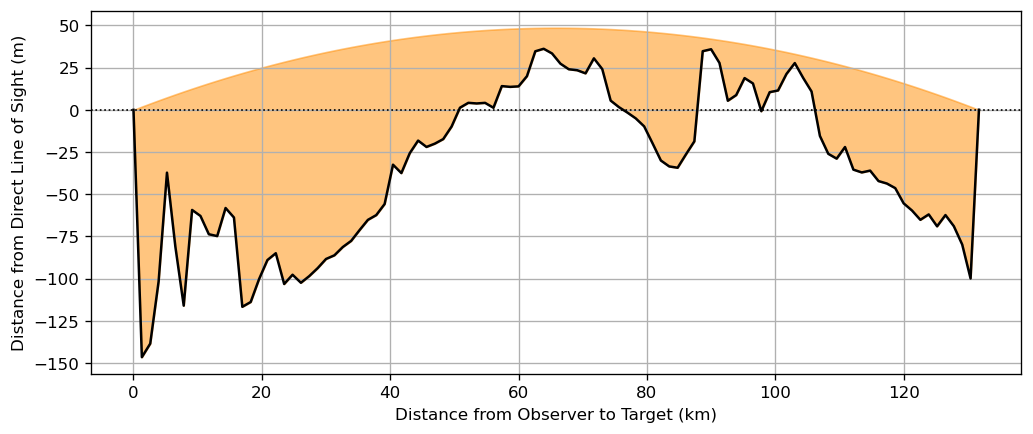

Higher Summits to Test Sight: 17
-72.2389, -99.0633 at 819.58 m is in view of 
-73.6681, -94.6633 at 1420.42 m (7 summits tested)


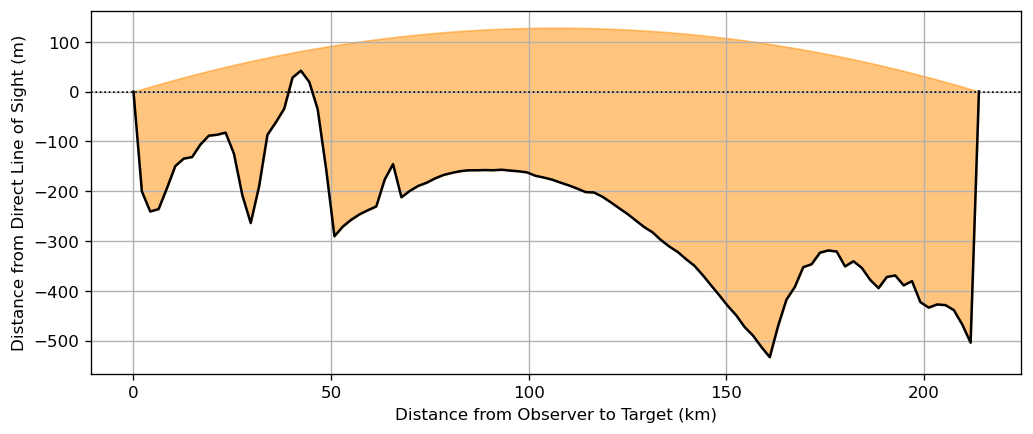

Higher Summits to Test Sight: 45
-16.175, 125.8181 at 813.5 m is in view of 
-17.2589, 125.4231 at 845.52 m (1 summits tested)


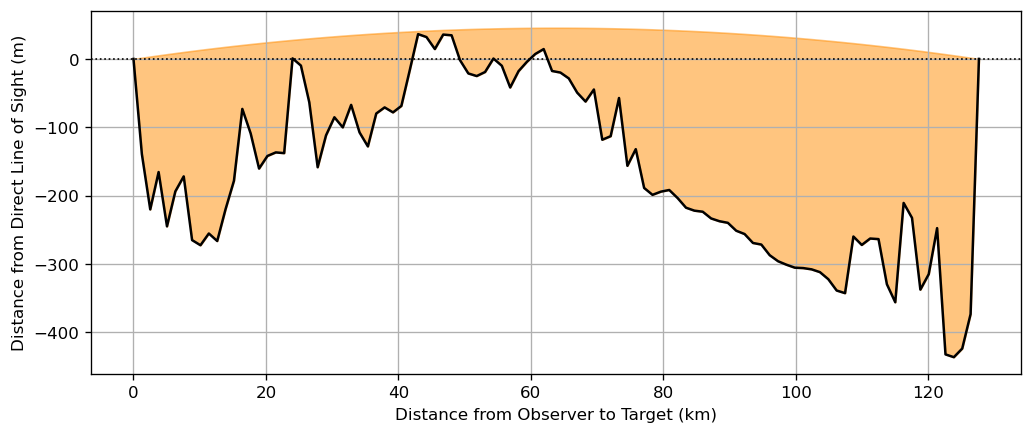

Higher Summits to Test Sight: 8
7.1328, -1.8861 at 804.82 m is in view of 
6.2503, -0.5758 at 846.2 m (3 summits tested)


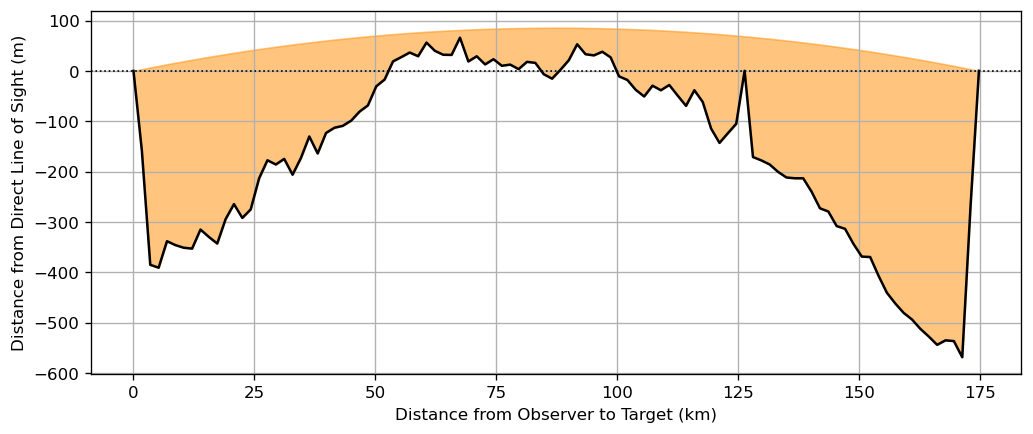

Higher Summits to Test Sight: 945
79.8264, 23.8258 at 798.38 m is in view of 
79.1803, 17.5383 at 1445.49 m (23 summits tested)


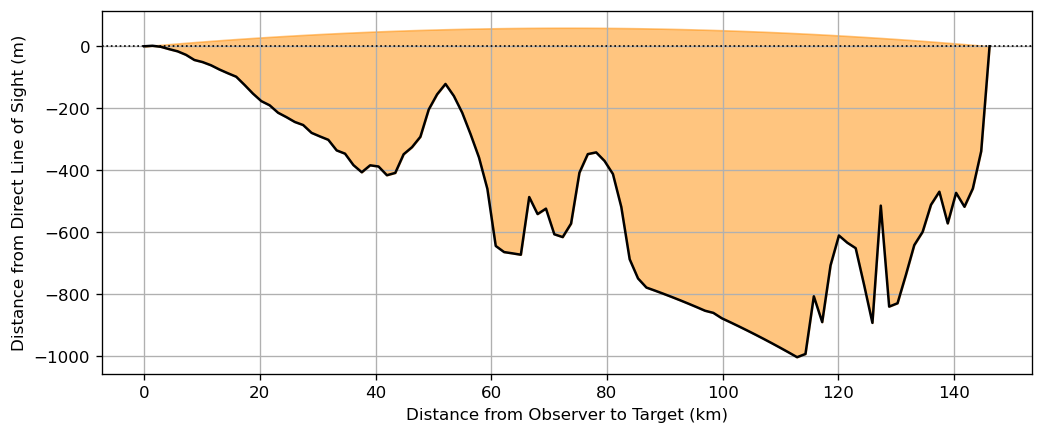

Higher Summits to Test Sight: 52
57.5911, 59.7039 at 754.46 m is in view of 
58.7578, 59.4 at 863.31 m (1 summits tested)


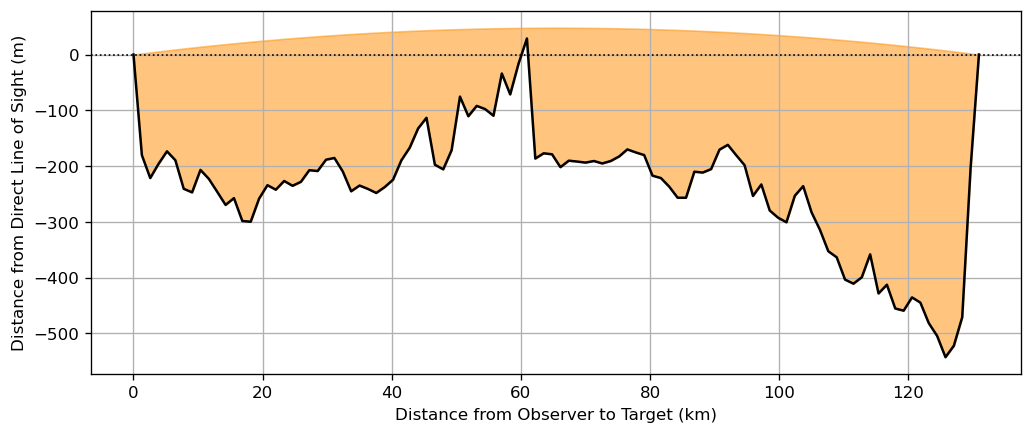

Higher Summits to Test Sight: 55
63.8064, -118.7861 at 746.61 m is in view of 
62.41, -119.5683 at 756.42 m (1 summits tested)


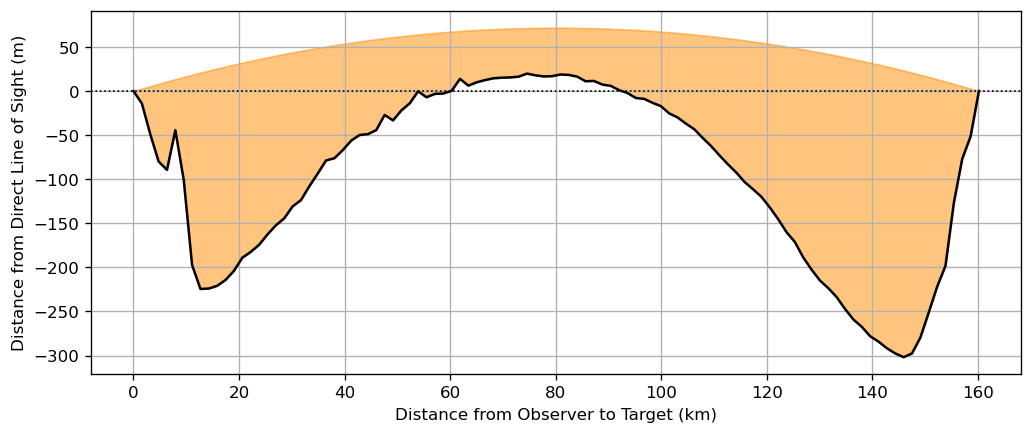

Higher Summits to Test Sight: 52
-6.3875, -51.89 at 740.03 m is in view of 
-7.5553, -52.1356 at 743.46 m (1 summits tested)


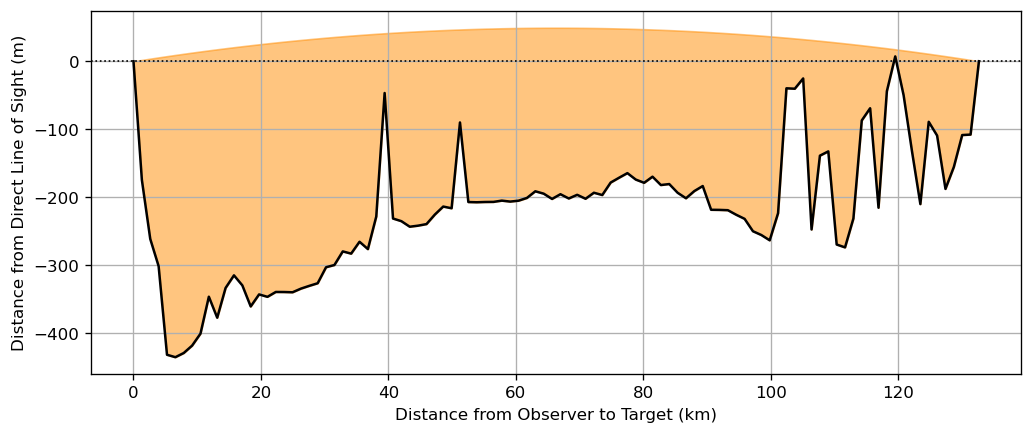

Higher Summits to Test Sight: 476
33.4856, -85.8087 at 733.65 m is in view of 
34.8897, -84.5741 at 1265.22 m (109 summits tested)


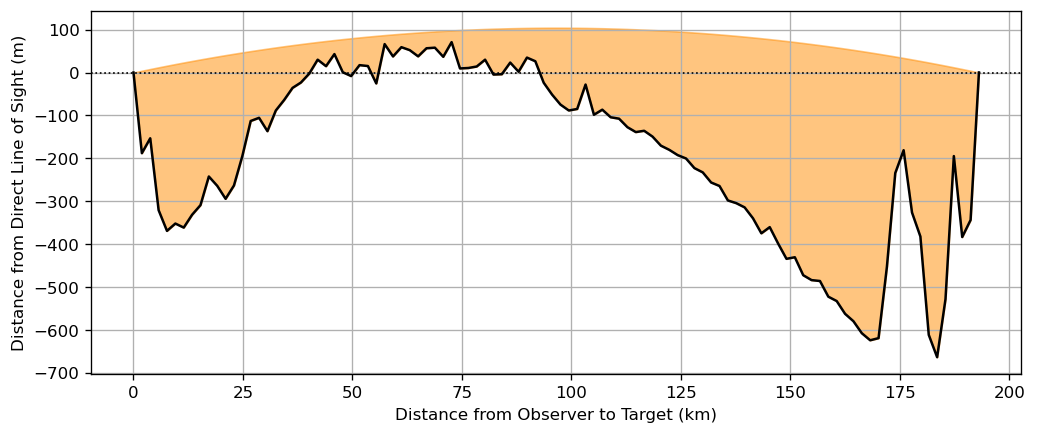

Higher Summits to Test Sight: 24
-73.1439, -102.3883 at 702.39 m is in view of 
-72.1269, -100.5558 at 745.54 m (5 summits tested)


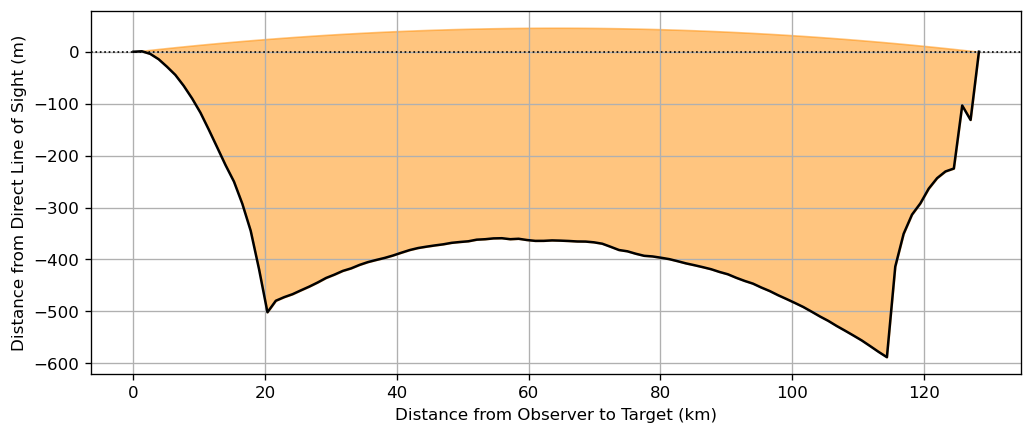

Higher Summits to Test Sight: 61
9.1225, 17.8269 at 693.25 m is in view of 
10.3161, 17.9081 at 699.69 m (1 summits tested)


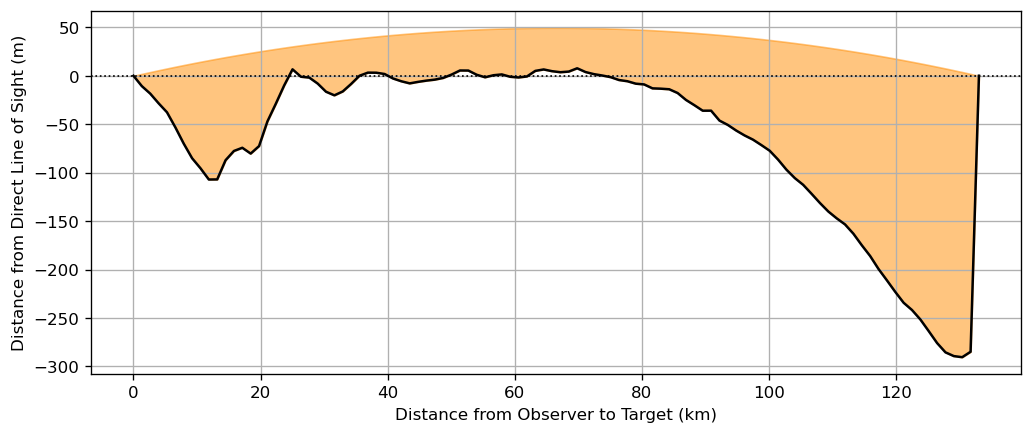

Higher Summits to Test Sight: 134
66.8861, 29.1894 at 656.96 m is in view of 
68.1253, 31.2733 at 938.73 m (11 summits tested)


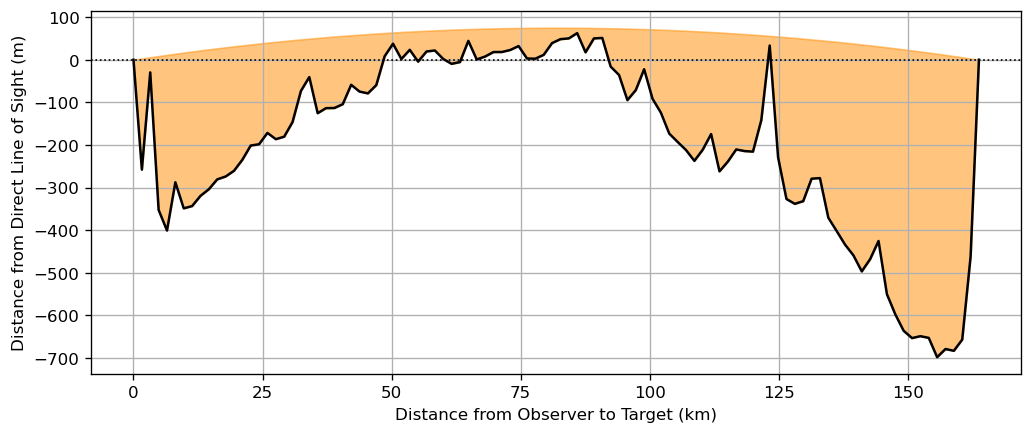

Higher Summits to Test Sight: 22
8.9467, -4.0147 at 652.88 m is in view of 
8.1244, -4.6639 at 671.49 m (1 summits tested)


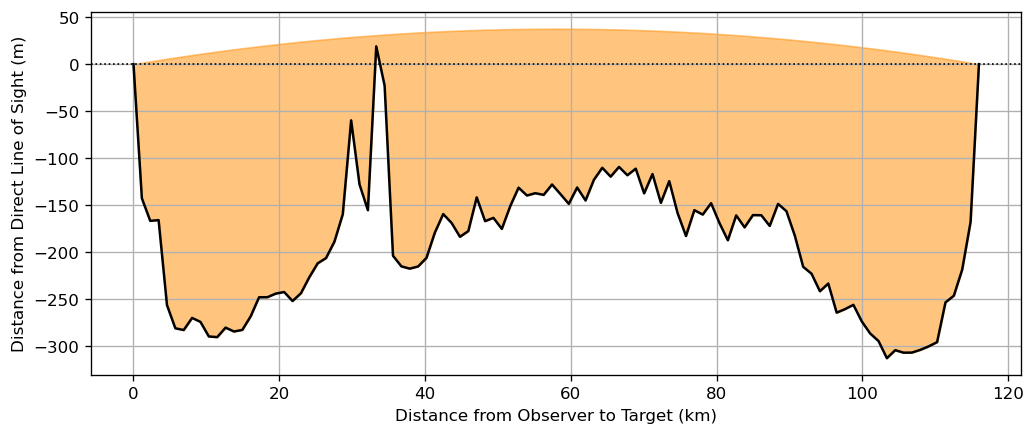

Higher Summits to Test Sight: 27
50.6853, -4.0111 at 617.46 m is in view of 
51.8681, -3.7767 at 632.51 m (1 summits tested)


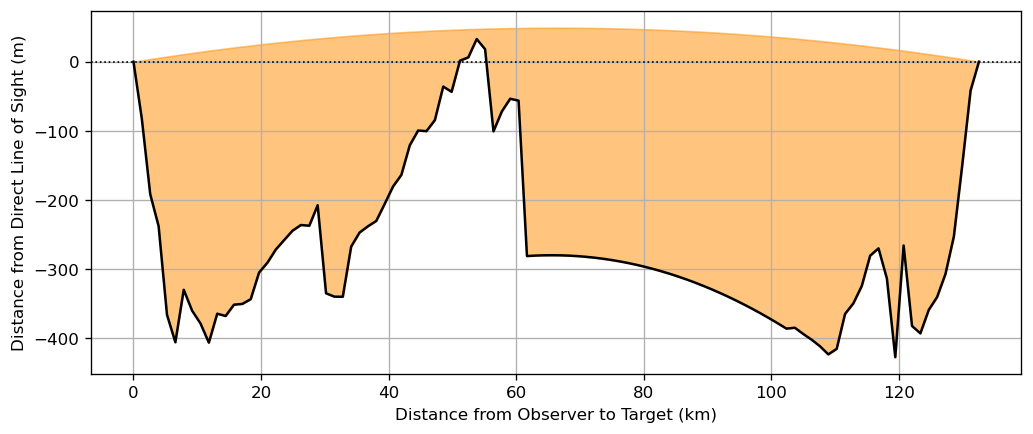

Higher Summits to Test Sight: 46
76.8306, -95.5417 at 565.7 m is in view of 
76.6369, -89.9933 at 585.93 m (1 summits tested)


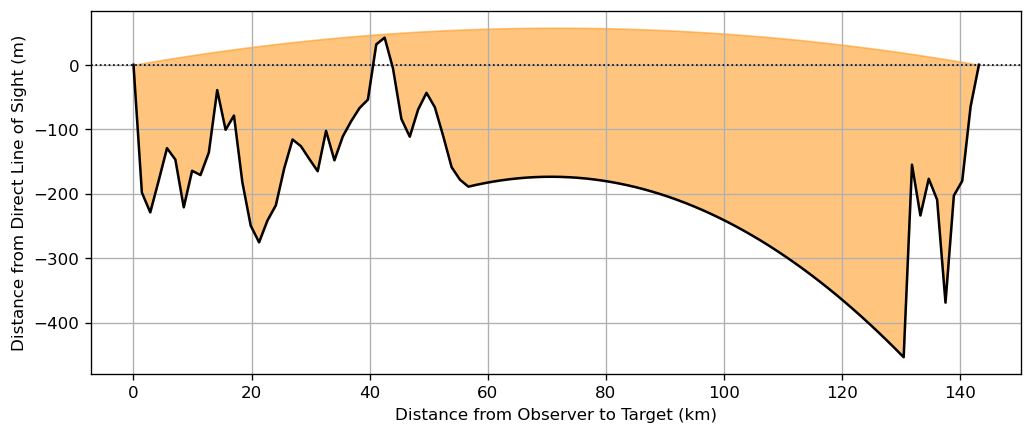

Higher Summits to Test Sight: 5
56.1086, -76.5436 at 450.89 m is in view of 
57.3247, -76.4669 at 464.3 m (1 summits tested)


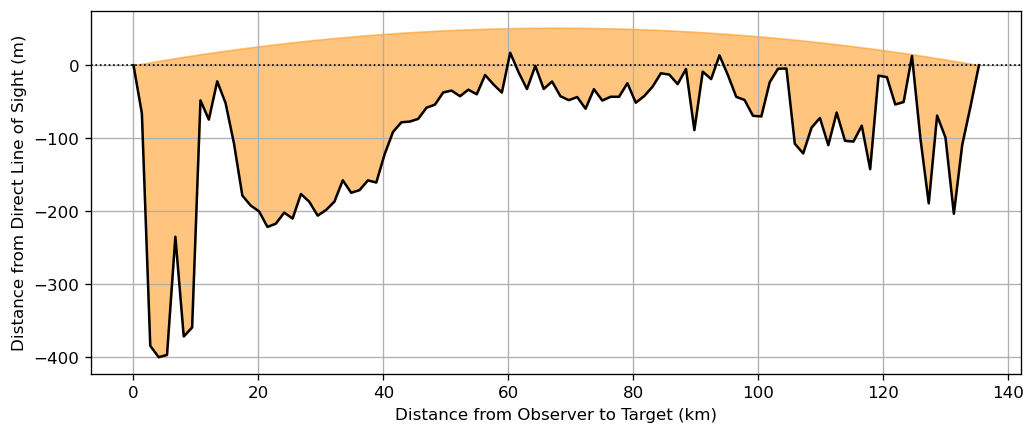

Higher Summits to Test Sight: 730
-70.2381, 26.3467 at 430.76 m is in view of 
-71.9519, 25.1267 at 2218.53 m (148 summits tested)


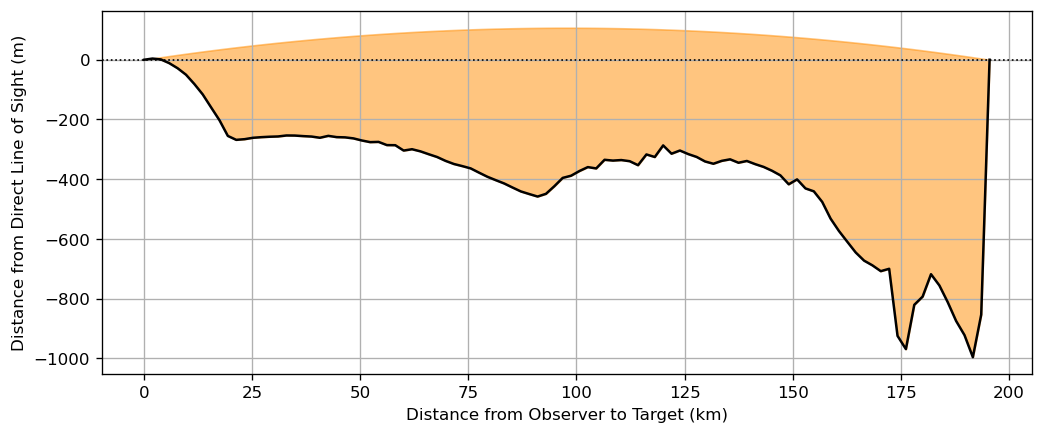

Higher Summits to Test Sight: 1
-21.4175, -174.9125 at 367.83 m is in view of 
-19.6681, -175.0161 at 1030.62 m (1 summits tested)


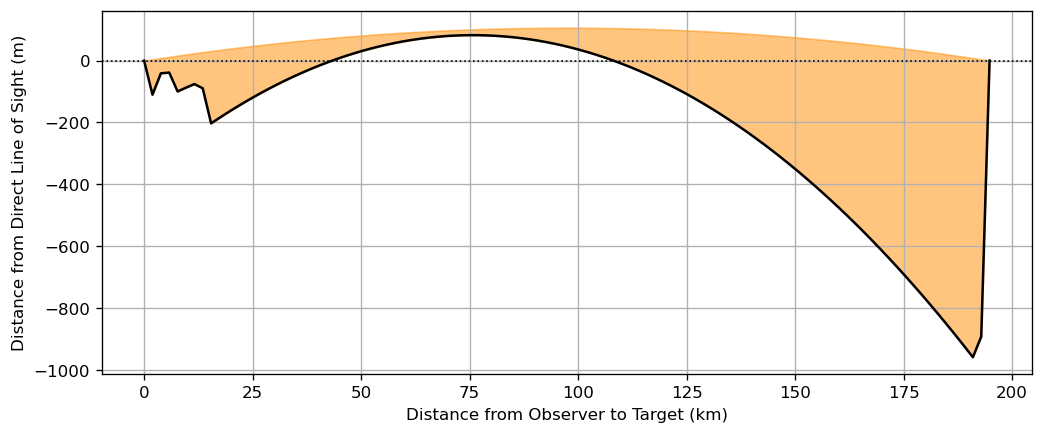

Higher Summits to Test Sight: 7
81.1619, 91.0056 at 346.45 m is in view of 
79.8964, 93.0158 at 408.53 m (2 summits tested)


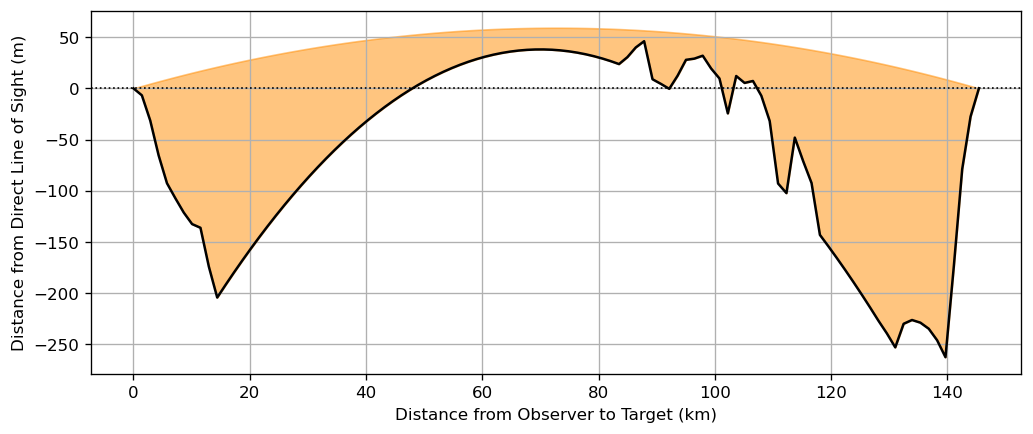

In [ ]:
# validating points omitted because of atmospheric refraction
def plotClosestLightPath(summit):
    patchSummits = func.getPatchSummits(summit[func.LAT], summit[func.LNG], summitPatches)
    return func.isPinnaclePoint(summit, patchSummits, plotClosestInfo=True)

pinnaclePointsDLOS = pd.read_csv('../dataSources/pinnaclePointsDLOS.txt', sep=',').fillna('')

omittedPinnaclePointsDLOS = pd.merge(pinnaclePointsDLOS, pinnaclePoints, on=['latitude', 'longitude', 'elevation'], how='left', indicator=True)
omittedPinnaclePointsDLOS = omittedPinnaclePointsDLOS[omittedPinnaclePointsDLOS['_merge'] == 'left_only']
omittedPinnaclePointsDLOS = omittedPinnaclePointsDLOS.drop('_merge', axis=1)
omittedPinnaclePointsDLOS = omittedPinnaclePointsDLOS[['latitude', 'longitude', 'elevation']]
omittedPinnaclePointsDLOS['h_distance'] = omittedPinnaclePointsDLOS.elevation.apply(func.horizonDistance).round(1)
omittedPinnaclePointsDLOS = omittedPinnaclePointsDLOS.reset_index()

# Not sure why this guy wasn't getting caught
omittedPinnaclePointsDLOS = omittedPinnaclePointsDLOS.query('latitude != 41.9991 and longitude != -74.3860')

placeHolder = omittedPinnaclePointsDLOS.apply(plotClosestLightPath, axis=1)